<a href="https://colab.research.google.com/github/marcela-acosta/thesis/blob/main/TesisX_SPY_Final_Comentarios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este notebook contiene la implementación experimental para la tesis de maestría. El objetivo es diseñar y validar un método de trading sistemático para el ETF SPY, comparando diferentes enfoques de modelado basados en Machine Learning contra un benchmark de Buy & Hold.

## 1. Configuración del entorno y carga de datos
En esta primera sección, se importan todas las librerías necesarias para el análisis y se cargan los datos históricos del SPDR S&P 500 ETF (SPY).

In [ ]:
# Instalar librerías
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.0 MB/s eta 0:00:00


In [ ]:
# Importar librerías
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
import warnings

from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
# Configuración de parámetros de Pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib')
pd.options.mode.chained_assignment = None

# En producción eliminar, se incluye por información
print(f'Pandas Version: {pd.__version__}')

Pandas Version: 2.2.2


In [ ]:
np.set_printoptions(suppress=True)

# En produccióon eliminar, se incluye por información
print(f'Numpy version: {np.__version__}')

Numpy version: 2.0.2


In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
# Para pandas: todos los floats en decimales normales, hasta 6 cifras decimales
pd.set_option('display.float_format', '{:.6f}'.format)

# Para numpy: print de arrays sin notación científica
np.set_printoptions(suppress=True, precision=6)

In [ ]:
# Definir Parámetros
ticker = "SPY"
inicio = "1993-01-29"
final = "2025-06-30"

In [ ]:
# Descargar datos diarios
df = yf.download(tickers=ticker, start=inicio, end=final, interval="1d", multi_level_index=False)
print(df.head())
print(df.tail())

[*********************100%***********************]  1 of 1 completed

               Close      High       Low      Open   Volume
Date                                                       
1993-01-29 24.380445 24.397786 24.276404 24.397786  1003200
1993-02-01 24.553841 24.553841 24.397778 24.397778   480500
1993-02-02 24.605871 24.623211 24.484489 24.536510   201300
1993-02-03 24.865974 24.883315 24.623210 24.640551   529400
1993-02-04 24.970020 25.022041 24.675235 24.952680   531500
                Close       High        Low       Open    Volume
Date                                                            
2025-06-23 600.150024 600.539978 591.890015 595.039978  87426000
2025-06-24 606.780029 607.849976 603.409973 604.330017  67735300
2025-06-25 607.119995 608.609985 605.539978 607.909973  62114800
2025-06-26 611.869995 612.309998 608.369995 608.989990  78548400
2025-06-27 614.909973 616.390015 610.830017 612.880005  86258400


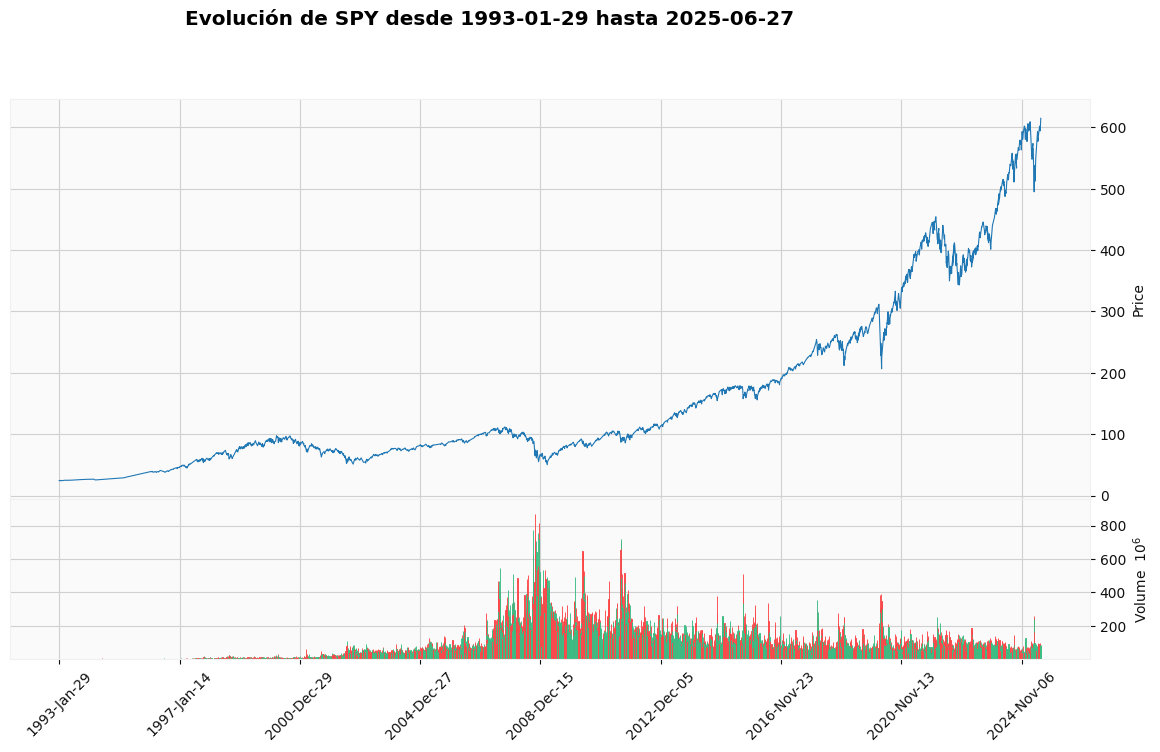

In [ ]:
# Graficar la evolución del SPY

mpf.plot(df, type="line", style="yahoo", volume=True, figsize=(15,8), figscale=2.0, title=f"Evolución de {ticker} desde {df.index[0].date()} hasta {df.index[-1].date()}")
plt.show()

In [ ]:
# Agregar el ATR(20) al dataframe

# Paso 1: desplazamos el Close para obtener el Close del día anterior
df['Prev_Close'] = df['Close'].shift(1)

# Paso 2: calculamos las tres componentes del True Range (TR)
df['TR1'] = df['High'] - df['Low']
df['TR2'] = (df['High'] - df['Prev_Close']).abs()
df['TR3'] = (df['Low']  - df['Prev_Close']).abs()

# Paso 3: el True Range es el máximo de esas tres series
df['TR'] = df[['TR1', 'TR2', 'TR3']].max(axis=1)

# Paso 4: calculamos el ATR(20) como media móvil simple de 20 periodos de TR
df['ATR20'] = df['TR'].rolling(window=20, min_periods=20).mean()

# Paso 5 (opcional): limpiar columnas auxiliares
df.drop(columns=['Prev_Close', 'TR1', 'TR2', 'TR3', 'TR'], inplace=True)

# Eliminar las filas NaN
df.dropna(inplace=True)

# Ahora df incluye la columna 'ATR20'
df.tail()

,Close,High,Low,Open,Volume,ATR20
Date,,,,,,
2025-06-23,600.150024,600.539978,591.890015,595.039978,87426000,6.538930
2025-06-24,606.780029,607.849976,603.409973,604.330017,67735300,6.550528
2025-06-25,607.119995,608.609985,605.539978,607.909973,62114800,6.061927
2025-06-26,611.869995,612.309998,608.369995,608.989990,78548400,6.033277
2025-06-27,614.909973,616.390015,610.830017,612.880005,86258400,5.955828


# 2. Análisis exploratorio de datos

In [ ]:
# Tasa de Crecimiento Anual Compuesta (CAGR)

# Precio inicial y precio final
precio_inicial = df['Close'].iloc[0]
precio_final = df['Close'].iloc[-1]

# Cálculo del número de años transcurridos
dias = (df.index[-1] - df.index[0]).days
años = dias / 365.25

# Fórmula del CAGR
cagr = (precio_final / precio_inicial)**(1/años) - 1

# Resultado
print(f"CAGR del SPY entre {df.index[0].date()} y {df.index[-1].date()}: {cagr:.2%}")

CAGR del SPY entre 1993-02-26 y 2025-06-27: 10.46%


In [ ]:
# Volatilidad

# Calcular retornos diarios simples
df['Retorno_diario'] = df['Close'].pct_change()

# Eliminar la primera fila con NaN en Retorno_diario
df_ret = df.dropna(subset=['Retorno_diario'])

# Volatilidad diaria: desviación estándar de los retornos diarios
volatilidad_diaria = df_ret['Retorno_diario'].std()

# Volatilidad anualizada (√252 días hábiles)
volatilidad_anual = volatilidad_diaria * np.sqrt(252)

print(f"Volatilidad diaria: {volatilidad_diaria:.2%}")
print(f"Volatilidad anualizada: {volatilidad_anual:.2%}")

# Borrar la columna Retorno_diario
df.drop(columns=['Retorno_diario'], inplace=True)

Volatilidad diaria: 1.18%
Volatilidad anualizada: 18.74%


In [ ]:
# Definimos la tasa libre de riesgo anual (asumimos un 0,00 %)
tasa_anual = 0.00

# Convertir a tasa diaria equivalente
tasa_diaria = (1 + tasa_anual) ** (1/252) - 1

# Calcular los retornos diarios y eliminar el primer NaN
retornos = df['Close'].pct_change().dropna()

# Exceso de retornos sobre la tasa libre de riesgo
retornos_exceso = retornos - tasa_diaria


# Coeficiente de Sharpe

sharpe = (retornos_exceso.mean() / retornos_exceso.std()) * np.sqrt(252)
print(f"Coeficiente de Sharpe entre {df.index[0].date()} y {df.index[-1].date()}: {sharpe:.2f}")

Coeficiente de Sharpe entre 1993-02-26 y 2025-06-27: 0.63


In [ ]:
# Coeficiente de Sortino

retornos_negativos = retornos_exceso[retornos_exceso < 0]
sortino = (retornos_exceso.mean() / retornos_negativos.std()) * np.sqrt(252)
print(f"Coeficiente de Sortino entre {df.index[0].date()} y {df.index[-1].date()}: {sortino:.2f}")

Coeficiente de Sortino entre 1993-02-26 y 2025-06-27: 0.80


In [ ]:
# Retroceso Máximo

max_drawdown = ((df['Close'].cummax() - df['Close']) / df['Close'].cummax()).max()
print(f"Retroceso Máximo: {max_drawdown:.2%}")

Retroceso Máximo: 55.19%


In [ ]:
# Cálculo del Calmar Ratio

calmar = cagr / max_drawdown
print(f"Calmar Ratio: {calmar:.2f}")

Calmar Ratio: 0.19


# 3. Ingeniería de características

## Creación de eventos informativos

In [ ]:
# Parámetros
TP_SL_MULT  = 2.0  # multiplicador para TP y SL (2×ATR20)
UMBRAL_MULT = 2.0  # threshold = ATR20 * UMBRAL_MULT

# Asumimos que `df` ya contiene las columnas:
# 'Open', 'High', 'Low', 'Close', 'Volume', 'ATR20' (sin NaN en ATR20)

barras_info = []

# 1) Evento inicial (fila 0)
row0      = df.iloc[0]
price_ref = row0['Close']
atr_ref   = row0['ATR20']
idx0      = df.index[0]

barras_info.append({
    "Fecha_Cierre":  idx0,
    "Precio_Cierre": price_ref,
    "Volume":        np.nan,
    "ATR20":         atr_ref
})

vol_acum = 0.0

# 2) Iteración para detectar y registrar eventos
for i in range(1, len(df)):
    row      = df.iloc[i]
    vol_acum += row['Volume']
    o, h, l  = row['Open'], row['High'], row['Low']

    # Calculamos niveles basados en el evento previo
    threshold = atr_ref * UMBRAL_MULT
    tp_level  = price_ref + threshold
    sl_level  = price_ref - threshold

    cierre = None

    # 2.1 GAP: si la apertura cruza el threshold
    if o >= tp_level or o <= sl_level:
        cierre = o

    # 2.2 Cruce intravela al alza
    elif h >= tp_level:
        cierre = tp_level

    # 2.3 Cruce intravela a la baja
    elif l <= sl_level:
        cierre = sl_level

    if cierre is None:
        continue  # no hubo evento en esta vela

    # 3) Registramos el evento
    barras_info.append({
        "Fecha_Cierre":  df.index[i],
        "Precio_Cierre": cierre,
        "Volume":        vol_acum,
        "ATR20":         row['ATR20']
    })

    # 4) Preparamos variables para el siguiente evento
    price_ref = cierre
    atr_ref   = row['ATR20']
    vol_acum  = 0.0

# 5) Construcción del DataFrame final y cálculo de TP/SL
df_barras = pd.DataFrame(barras_info)
df_barras['TP'] = df_barras['Precio_Cierre'] + TP_SL_MULT * df_barras['ATR20']
df_barras['SL'] = df_barras['Precio_Cierre'] - TP_SL_MULT * df_barras['ATR20']


print(f"Total de barras informativas: {len(df_barras)}")
display(df_barras.head(10))

Total de barras informativas: 1005


,Fecha_Cierre,Precio_Cierre,Volume,ATR20,TP,SL
0,1993-02-26,24.640545,NaN,0.230624,25.101793,24.179297
1,1993-03-08,25.101793,709300.000000,0.250566,25.602926,24.600660
2,1993-04-02,24.600660,2498800.000000,0.219893,25.040446,24.160875
3,1993-04-12,25.040446,859200.000000,0.201942,25.444329,24.636562
4,1993-04-22,24.636562,1064300.000000,0.208195,25.052953,24.220172
5,1993-04-26,24.220172,168600.000000,0.215164,24.650499,23.789844
6,1993-04-30,24.650499,416200.000000,0.222131,25.094762,24.206236
7,1993-05-19,25.094762,1030800.000000,0.214293,25.523348,24.666176
8,1993-06-01,25.523348,805500.000000,0.206454,25.936256,25.110439
9,1993-06-08,25.087944,299800.000000,0.216037,25.520019,24.655870


## Análisis de Estacionariedad

**Test de Dickey-Fuller aumentado (ADF)**

In [ ]:
# Calcular retornos porcentuales sin eliminar ninguna fila del DataFrame
df_barras['Retorno_pct'] = df_barras['Precio_Cierre'].pct_change()

# --- Test de Dickey-Fuller aumentado (ADF) ---
from statsmodels.tsa.stattools import adfuller

# Solo eliminamos NaN para el test, nunca en df_barras
serie_test = df_barras['Retorno_pct'].dropna()

resultado_adf = adfuller(serie_test)

adf_stat = resultado_adf[0]
p_value  = resultado_adf[1]
n_lags   = resultado_adf[2]
n_obs    = resultado_adf[3]

print(f"Estadístico ADF: {adf_stat:.4f}")
print(f"p-valor: {p_value:.4f}")
print(f"Número de rezagos usados: {n_lags}")
print(f"Número de observaciones usadas: {n_obs}")

if p_value < 0.05:
    print("✔️ La serie es estacionaria (rechaza la hipótesis nula de raíz unitaria).")
else:
    print("❌ La serie NO es estacionaria (no se puede rechazar la hipótesis nula).")

Estadístico ADF: -11.6107
p-valor: 0.0000
Número de rezagos usados: 7
Número de observaciones usadas: 996
✔️ La serie es estacionaria (rechaza la hipótesis nula de raíz unitaria).


**Visualización**

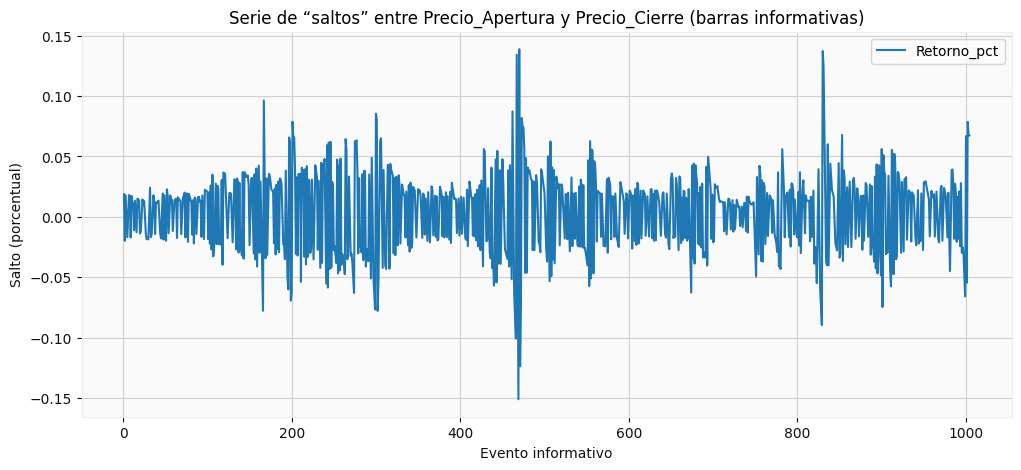

In [ ]:
# --- Visualización ---
plt.figure(figsize=(12,5))
plt.plot(df_barras.index, df_barras['Retorno_pct'], label='Retorno_pct')
plt.title('Serie de “saltos” entre Precio_Apertura y Precio_Cierre (barras informativas)')
plt.xlabel('Evento informativo')
plt.ylabel('Salto (porcentual)')
plt.legend()
plt.show()

**Test de KPSS**

In [ ]:
from statsmodels.tsa.stattools import kpss

# Usamos la misma serie de saltos que antes (sin modificar df_barras)
resultado_kpss = kpss(serie_test, regression='c', nlags='auto')

kpss_stat  = resultado_kpss[0]
p_value    = resultado_kpss[1]
n_lags     = resultado_kpss[2]

print(f"Estadístico KPSS: {kpss_stat:.4f}")
print(f"p-valor: {p_value:.4f}")
print(f"Número de lags usados: {n_lags}")

if p_value < 0.05:
    print("❌ La serie NO es estacionaria según KPSS (se rechaza la hipótesis nula).")
else:
    print("✔️ La serie es estacionaria según KPSS (no se rechaza la hipótesis nula).")

Estadístico KPSS: 0.0583
p-valor: 0.1000
Número de lags usados: 11
✔️ La serie es estacionaria según KPSS (no se rechaza la hipótesis nula).


/tmp/ipython-input-1396027741.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  resultado_kpss = kpss(serie_test, regression='c', nlags='auto')


**Diagnóstico de Correlación y Distribución de Saltos**

<Figure size 1000x400 with 0 Axes>

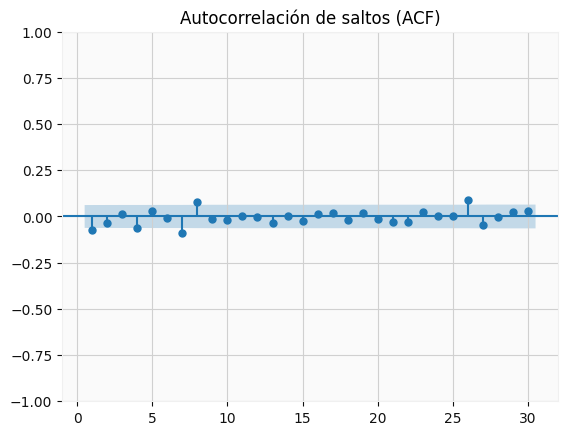

<Figure size 1000x400 with 0 Axes>

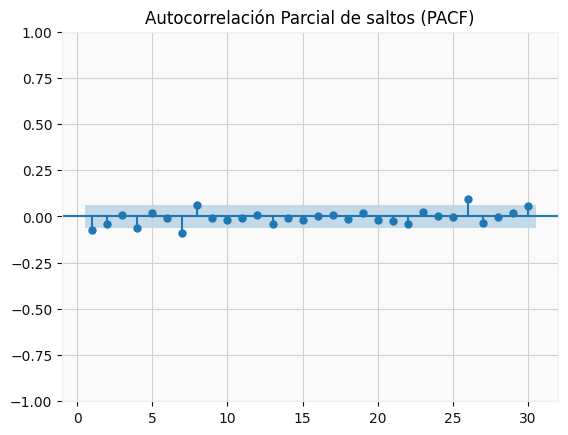

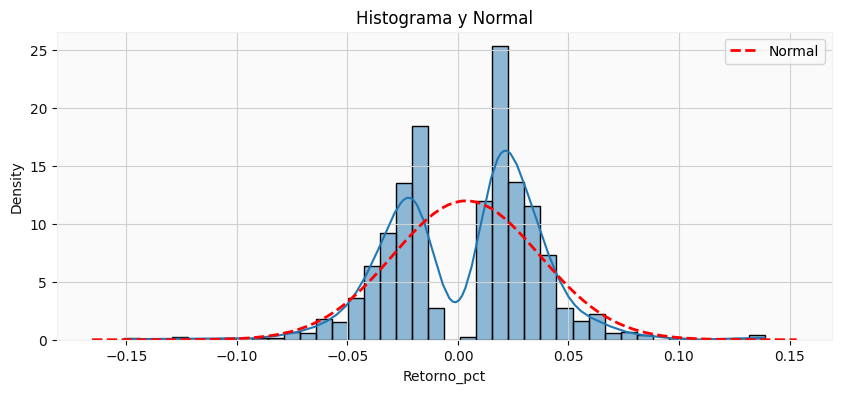

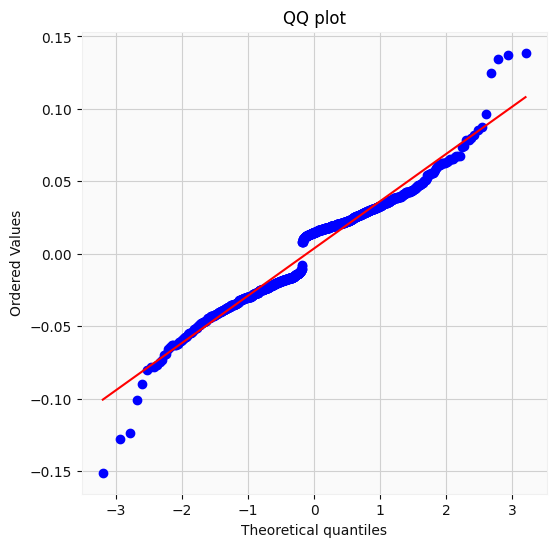

Media:     0.0037
Desvío:    0.0333
Skewness:  -0.14
Kurtosis:  0.79


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import skew, kurtosis, norm, probplot

# 1. Autocorrelación
plt.figure(figsize=(10,4))
plot_acf(serie_test, lags=30, zero=False)
plt.title("Autocorrelación de saltos (ACF)")
plt.show()

plt.figure(figsize=(10,4))
plot_pacf(serie_test, lags=30, zero=False)
plt.title("Autocorrelación Parcial de saltos (PACF)")
plt.show()

# 2. Distribución
plt.figure(figsize=(10,4))
sns.histplot(serie_test, bins=40, kde=True, stat="density")
mu, sigma = serie_test.mean(), serie_test.std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
plt.plot(x, norm.pdf(x, mu, sigma), 'r--', lw=2, label='Normal')
plt.title('Histograma y Normal')
plt.legend()
plt.show()

# QQ plot
plt.figure(figsize=(6,6))
probplot(serie_test, dist="norm", plot=plt)
plt.title('QQ plot')
plt.show()

# Estadísticos
print(f"Media:     {mu:.4f}")
print(f"Desvío:    {sigma:.4f}")
print(f"Skewness:  {skew(serie_test):.2f}")
print(f"Kurtosis:  {kurtosis(serie_test, fisher=True):.2f}")

## Etiquetar la variable objetivo

In [ ]:
# Etiqueta: 1 si Precio_Cierre siguiente es mayor a Precio_Cierre actual, de lo contario, 0
df_barras['Objetivo'] = (df_barras['Precio_Cierre'].shift(-1) > df_barras['Precio_Cierre']).astype(int)

In [ ]:
# Contar cuántas veces aparece cada valor en 'Objetivo' y calcular proporción
conteo_objetivo = df_barras['Objetivo'].value_counts()
proporcion_objetivo = conteo_objetivo / len(df_barras)

print("Conteo de 'Objetivo':")
print(conteo_objetivo)

print("\nProporción de 'Objetivo':")
print(proporcion_objetivo)

Conteo de 'Objetivo':
Objetivo
1    574
0    431
Name: count, dtype: int64

Proporción de 'Objetivo':
Objetivo
1   0.571144
0   0.428856
Name: count, dtype: float64


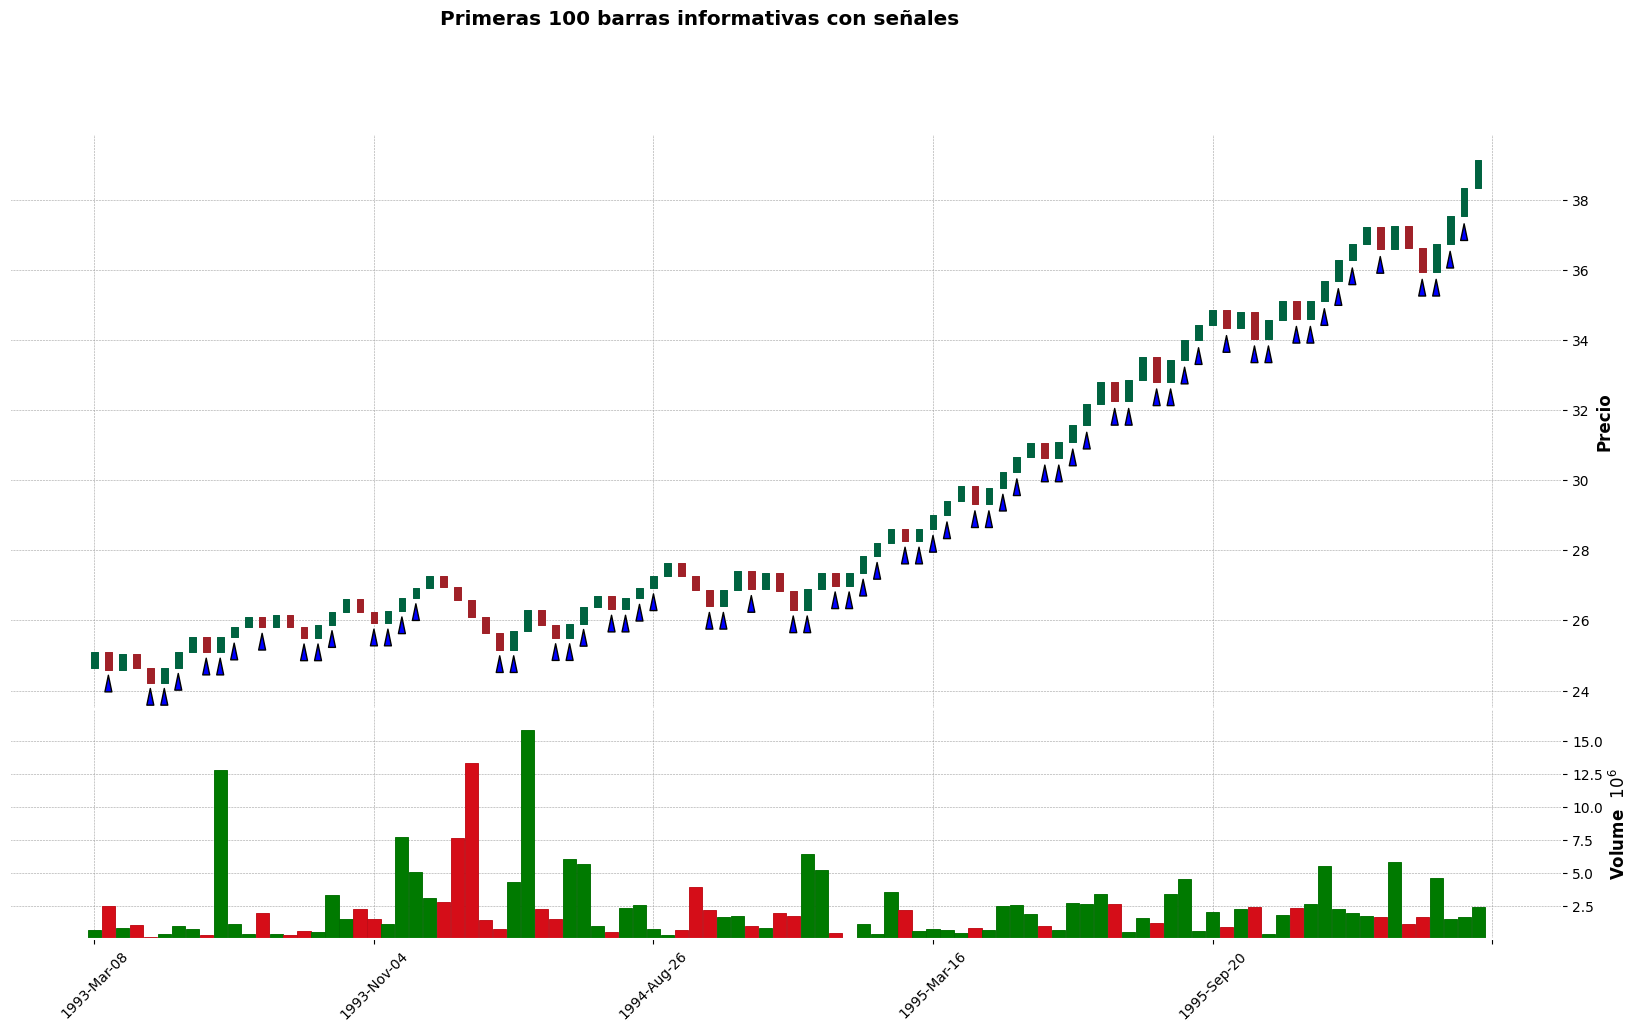

In [ ]:
# Prepara el DataFrame para el plot
df_barras_plot = df_barras.copy()

df_barras_plot['Open'] = df_barras_plot['Precio_Cierre'].shift(1)
df_barras_plot['High'] = df_barras_plot[['Open', 'Precio_Cierre']].max(axis=1)
df_barras_plot['Low'] = df_barras_plot[['Open', 'Precio_Cierre']].min(axis=1)
df_barras_plot = df_barras_plot.dropna().reset_index(drop=True).head(100)

df_barras_plot['Fecha_Cierre'] = pd.to_datetime(df_barras_plot['Fecha_Cierre'])
df_barras_plot = df_barras_plot.set_index('Fecha_Cierre')
df_barras_plot.rename(columns={'Precio_Cierre': 'Close'}, inplace=True)

# El volumen ya está acumulado en df_barras_plot['Volume']

columns_for_plot = ['Open', 'High', 'Low', 'Close', 'Volume']

# Creamos la figura de mplfinance y guardamos axes
fig, ax = mpf.plot(
    df_barras_plot[columns_for_plot],
    type='candle',
    style='charles',
    title='Primeras 100 barras informativas con señales',
    ylabel='Precio',
    figratio=(15,8),
    figscale=2.0,
    volume=True,
    returnfig=True
)

# Extrae la lista de fechas (índice) como array
fechas = df_barras_plot.index.to_list()
close_max = df_barras_plot['Close'].max()
# Calcula el desplazamiento vertical para las flechas (ajústalo si lo ves muy arriba/abajo)
offset = close_max * 0.01

# Define la columna de señal (ajusta el nombre según tu DataFrame)
signal_idx = df_barras_plot[df_barras_plot['Objetivo'] == 1].index
signal_prices = df_barras_plot.loc[signal_idx, 'Low'] * 0.995  # Un poco debajo del mínimo

# Dibuja flechas para cada señal
for fecha, low in zip(signal_idx, signal_prices):
    xpos = fechas.index(fecha)
    ax[0].annotate(
        '',
        xy=(xpos, low),
        xytext=(xpos, low - offset),
        arrowprops=dict(facecolor='blue', shrink=0.1, width=1.5, headwidth=5),
        ha='center'
    )

# Asegúrate de mostrar el gráfico completo
plt.show()

## Construir variables independientes

In [ ]:
# VIX
# Definir Parámetros
ticker_vix = "^VIX"
inicio_vix = "1993-01-29"
final_vix = "2025-06-30"

In [ ]:
# Descargar datos diarios
vix = yf.download(tickers=ticker_vix, start=inicio_vix, end=final_vix, interval="1d", multi_level_index=False)
print(vix.head())
print(vix.tail())

[*********************100%***********************]  1 of 1 completed

               Close      High       Low      Open  Volume
Date                                                      
1993-01-29 12.420000 13.160000 12.420000 12.490000       0
1993-02-01 12.330000 12.920000 12.180000 12.510000       0
1993-02-02 12.250000 12.890000 12.220000 12.470000       0
1993-02-03 12.120000 12.340000 11.790000 11.980000       0
1993-02-04 12.290000 12.840000 11.690000 11.860000       0
               Close      High       Low      Open  Volume
Date                                                      
2025-06-23 19.830000 22.510000 19.820000 21.150000       0
2025-06-24 17.480000 18.719999 17.330000 18.190001       0
2025-06-25 16.760000 17.510000 16.680000 17.280001       0
2025-06-26 16.590000 16.780001 16.110001 16.670000       0
2025-06-27 16.320000 17.290001 16.120001 16.309999       0


In [ ]:
# --- 1. Asegurar tipos y nombres ---
# Convierte Fecha_Inicio a datetime (si no lo está ya)
df_barras['Fecha_Cierre'] = pd.to_datetime(df_barras['Fecha_Cierre'])
# Asegura que el índice de vix sea datetime
vix.index = pd.to_datetime(vix.index)

# --- 2. Mapear el Open de VIX al df_barras ---
# Renombra la serie para claridad
serie_vix = vix['Open'].rename('VIX_Open')

# Usamos map() para asignar, vía índice de fechas
df_barras['VIX_Open'] = df_barras['Fecha_Cierre'].map(serie_vix)

# --- 3. Verificar resultado ---
print(df_barras[['Fecha_Cierre', 'Precio_Cierre', 'VIX_Open']].head())

  Fecha_Cierre  Precio_Cierre  VIX_Open
0   1993-02-26      24.640545 13.470000
1   1993-03-08      25.101793 15.000000
2   1993-04-02      24.600660 14.270000
3   1993-04-12      25.040446 12.330000
4   1993-04-22      24.636562 11.580000


In [ ]:
# Retorno de los últimos 10 días
# ------------------------------------------------------
df_barras['Retornos_10'] = df_barras['Precio_Cierre'].pct_change(periods=10)

In [ ]:
# Eliminar columnas con NaN
df_barras.dropna(inplace=True)

In [ ]:
# Resetear el index
df_barras.reset_index(drop=True, inplace=True)

In [ ]:
df_barras.head()

,Fecha_Cierre,Precio_Cierre,Volume,ATR20,TP,SL,Retorno_pct,Objetivo,VIX_Open,Retornos_10
0,1993-08-16,25.520019,12847800.000000,0.145630,25.811278,25.228759,0.017222,1,12.370000,0.035692
1,1993-08-24,25.811278,1181800.000000,0.139486,26.090250,25.532305,0.011413,1,11.940000,0.028264
2,1993-08-26,26.090250,362300.000000,0.144750,26.379750,25.800750,0.010808,0,11.850000,0.060551
3,1993-09-08,25.800750,1981400.000000,0.150890,26.102529,25.498971,-0.011096,1,12.260000,0.030363
4,1993-09-13,26.143028,412600.000000,0.157908,26.458844,25.827213,0.013266,0,11.670000,0.061148


## Dividir el dataframe entre Entrenamiento (90%) y Hold-out (10%)

In [ ]:
# ------------------------------
# División Train / Hold-Out 900/final
# ------------------------------

# Número total de barras
n_barras = len(df_barras)

# Primer 900 barras
df_train = df_barras.iloc[:900].reset_index(drop=True)

# Últimas → hold-out
df_holdout = df_barras.iloc[900:].reset_index(drop=True)

# Comprobación de tamaños
print(f"Total barras:     {n_barras}")
print(f"Entrenamiento:    {len(df_train)} barras ({len(df_train)/n_barras:.1%})")
print(f"Hold-out final:   {len(df_holdout)} barras ({len(df_holdout)/n_barras:.1%})")

Total barras:     995
Entrenamiento:    900 barras (90.5%)
Hold-out final:   95 barras (9.5%)


## Dividir en Folds de Entrenamiento y Validación

In [ ]:
# Parámetros de tamaño de ventana
num_train = 500
num_val   = 40

# Lista que contendrá tuplas (índices_train, índices_val)
folds = []

# Recorrer en pasos del tamaño de la validación para solapamiento rolling
for start in range(0, len(df_train) - num_train - num_val + 1, num_val):
    # Definir rango de posiciones para train y validación
    train_pos = slice(start, start + num_train)
    val_pos   = slice(start + num_train, start + num_train + num_val)

    # Extraer los índices reales del DataFrame
    idx_train = df_train.index[train_pos]
    idx_val   = df_train.index[val_pos]

    folds.append((idx_train, idx_val))

# Ejemplo: imprimir el número de folds obtenidos
print(f"Total de folds: {len(folds)}")
for i, (tr, va) in enumerate(folds, 1):
    print(f"Fold {i}: train [{tr[0]} → {tr[-1]}], val [{va[0]} → {va[-1]}]")


Total de folds: 10
Fold 1: train [0 → 499], val [500 → 539]
Fold 2: train [40 → 539], val [540 → 579]
Fold 3: train [80 → 579], val [580 → 619]
Fold 4: train [120 → 619], val [620 → 659]
Fold 5: train [160 → 659], val [660 → 699]
Fold 6: train [200 → 699], val [700 → 739]
Fold 7: train [240 → 739], val [740 → 779]
Fold 8: train [280 → 779], val [780 → 819]
Fold 9: train [320 → 819], val [820 → 859]
Fold 10: train [360 → 859], val [860 → 899]


## Funciones auxiliares

In [ ]:
# -- FUNCIONES ESTÁNDAR DE BACKTEST Y MÉTRICAS --
def ejecutar_backtest(df, signal_col='Signal', capital_inicial=100_000.0, riesgo_pct=0.02, spread=0.01, comision_por_accion=0.001):
    riesgo_abs = capital_inicial * riesgo_pct
    df = df.copy().reset_index(drop=True)
    df['EntryPrice'] = df['Precio_Cierre']
    df['ExitPrice']  = df['Precio_Cierre'].shift(-1)
    mask = df[signal_col] == 1
    df['Distance'] = np.nan
    df.loc[mask, 'Distance'] = np.abs(df.loc[mask, 'EntryPrice'] - df.loc[mask, 'SL'])
    df['Shares'] = 0.0
    valid = (df[signal_col]==1) & (df['Distance']>0)
    df.loc[valid, 'Shares'] = riesgo_abs / df.loc[valid, 'Distance']
    df = df.iloc[:-1].copy()
    df['GrossPnL'] = df['Shares'] * (df['ExitPrice'] - df['EntryPrice'])
    df['Cost']     = df['Shares'] * (spread + comision_por_accion)
    df['NetPnL']   = df['GrossPnL'] - df['Cost']
    df['Equity']   = capital_inicial + df['NetPnL'].cumsum()
    return df

def extraer_metricas(df_bt):
    equity = df_bt['Equity']
    if len(equity) < 2:
        return [np.nan]*7
    rets = df_bt['NetPnL'] / equity.iloc[0]
    years = (pd.to_datetime(df_bt['Fecha_Cierre'].iloc[-1]) - pd.to_datetime(df_bt['Fecha_Cierre'].iloc[0])).days / 365.25
    if years <= 0: years = 1/365.25
    mean_ret = rets.mean()
    std_ret  = rets.std(ddof=0)
    events_per_year = len(rets) / years
    sharpe   = (mean_ret / std_ret) * np.sqrt(events_per_year) if std_ret>0 else np.nan
    neg_rets = rets[rets < 0]
    sortino  = (mean_ret / neg_rets.std(ddof=0)) * np.sqrt(events_per_year) if len(neg_rets)>0 else np.nan
    cagr     = (equity.iloc[-1] / equity.iloc[0]) ** (1/years) - 1
    running_max = equity.cummax()
    drawdowns   = equity / running_max - 1
    mdd         = drawdowns.min()
    hit_rate    = (df_bt['NetPnL'] > 0).mean()
    wins        = df_bt['NetPnL'][df_bt['NetPnL']>0].sum()
    loses       = -df_bt['NetPnL'][df_bt['NetPnL']<0].sum()
    profit_factor = wins / loses if loses > 0 else np.nan
    return sharpe, sortino, cagr, mdd, hit_rate, profit_factor, events_per_year

## Entrenamiento y evaluación HMM

In [ ]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 2.7 MB/s eta 0:00:00


In [ ]:
!pip install XlsxWriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 2.3 MB/s eta 0:00:00


In [ ]:
from hmmlearn.hmm import GaussianHMM

n_states = 4
n_iter = 200
random_state = 42
features = ['VIX_Open', 'Retornos_10']
epsilon_jitter = 1e-6

hmm_models = []

for i, (idx_train, idx_val) in enumerate(folds, start=1):
    X_tr = df_train.loc[idx_train, features].values.copy()
    X_va = df_train.loc[idx_val, features].values.copy()
    X_tr += epsilon_jitter * np.random.randn(*X_tr.shape)
    X_va += epsilon_jitter * np.random.randn(*X_va.shape)
    try:
        model = GaussianHMM(
            n_components=n_states,
            covariance_type='full',
            n_iter=n_iter,
            random_state=random_state
        )
        model.fit(X_tr)
    except ValueError:
        model = GaussianHMM(
            n_components=n_states,
            covariance_type='diag',
            n_iter=n_iter,
            random_state=random_state
        )
        model.fit(X_tr)
    hmm_models.append(model)

# ===========================
# 1. DEFINIR FUNCIONES Y VARIABLES
# ===========================

def calcular_metricas_equity(equity, fechas):
    equity = np.array(equity)
    fechas = pd.to_datetime(fechas)
    start, end = fechas[0], fechas[-1]
    years = (end - start).days / 365.25
    if years <= 0: years = 1/365.25
    rets = pd.Series(equity).pct_change().dropna()
    mean_ret = rets.mean()
    std_ret  = rets.std(ddof=0)
    sharpe   = (mean_ret / std_ret) * np.sqrt(len(rets) / years) if std_ret > 0 else np.nan
    neg_rets = rets[rets < 0]
    sortino  = (mean_ret / neg_rets.std(ddof=0)) * np.sqrt(len(rets) / years) if len(neg_rets) > 0 else np.nan
    cagr = (equity[-1] / equity[0]) ** (1/years) - 1
    running_max = np.maximum.accumulate(equity)
    drawdowns = equity / running_max - 1
    mdd = drawdowns.min()
    calmar = cagr / abs(mdd) if mdd < 0 else np.nan
    return cagr, sharpe, sortino, mdd, calmar

# --- Definiciones de rolling folds, features y modelos ---
# Suponiendo que ya tienes df_train, folds y hmm_models definidos
# features = ['VIX_Open', 'Retornos_10']

# ===========================
# 2. EXPORTAR MÉTRICAS POR FOLD
# ===========================

excel_writer_metrics = pd.ExcelWriter("hmm_metrics_por_fold.xlsx", engine='openpyxl')
tabla_resumen = []

for i, ((idx_tr, _), model) in enumerate(zip(folds, hmm_models), start=1):
    # --- Obtener datos del fold
    fechas_tr = df_train.loc[idx_tr, 'Fecha_Cierre']
    precios_tr = df_train.loc[idx_tr, 'Precio_Cierre']
    X_tr = df_train.loc[idx_tr, features].values
    train_sts = model.predict(X_tr)

    # --- Métricas Buy & Hold
    equity_bh = precios_tr.values / precios_tr.iloc[0]
    cagr_bh, sharpe_bh, sortino_bh, mdd_bh, calmar_bh = calcular_metricas_equity(equity_bh, fechas_tr.values)

    # --- Métricas por Estado
    n_states = model.means_.shape[0]
    estado_metrics = []
    for estado in range(n_states):
        mask = (train_sts == estado)
        if mask.sum() < 2:
            metrics = (np.nan, np.nan, np.nan, np.nan, np.nan)
        else:
            precios_estado = precios_tr.values[mask]
            fechas_estado = fechas_tr.values[mask]
            equity_estado = precios_estado / precios_estado[0]
            metrics = calcular_metricas_equity(equity_estado, fechas_estado)
        estado_metrics.append(metrics)

    df_metrics = pd.DataFrame(estado_metrics, columns=['CAGR', 'Sharpe', 'Sortino', 'MDD', 'Calmar'])
    df_metrics.insert(0, 'Estado', range(n_states))
    df_metrics = df_metrics.round(4)
    # Agregar B&H como fila extra
    df_metrics_bh = pd.DataFrame([['Buy & Hold', cagr_bh, sharpe_bh, sortino_bh, mdd_bh, calmar_bh]],
                                 columns=df_metrics.columns)
    df_metrics_all = pd.concat([df_metrics, df_metrics_bh], ignore_index=True)
    # Guardar hoja por fold
    hoja = f"Fold_{i}"
    df_metrics_all.to_excel(excel_writer_metrics, sheet_name=hoja, index=False)
    # Para la hoja resumen global
    df_metrics_all['Fold'] = i
    tabla_resumen.append(df_metrics_all)

# --- Hoja resumen combinada ---
df_tabla_resumen = pd.concat(tabla_resumen, ignore_index=True)
df_tabla_resumen.to_excel(excel_writer_metrics, sheet_name='Resumen_Global', index=False)

excel_writer_metrics.close()
print("\nArchivo 'hmm_metrics_por_fold.xlsx' generado correctamente.")

# ===========================
# 3. EXPORTAR PARÁMETROS POR FOLD
# ===========================

excel_writer_params = pd.ExcelWriter("hmm_parametros_por_fold.xlsx", engine='openpyxl')
tabla_parametros = []

for i, ((idx_tr, _), model) in enumerate(zip(folds, hmm_models), start=1):
    raw_covars = model.covars_
    if raw_covars.ndim == 3:
        covars = np.array([np.diag(c) for c in raw_covars])
    else:
        covars = raw_covars
    means = model.means_
    stds  = np.sqrt(covars)
    n_states = means.shape[0]

    X_tr      = df_train.loc[idx_tr, features].values
    train_sts = model.predict(X_tr)
    proportions = np.bincount(train_sts, minlength=n_states) / len(train_sts)

    df_states = pd.DataFrame({
        'Fold':              i,
        'Estado':            np.arange(n_states),
        'Media_VIX_Open':    means[:, 0],
        'Std_VIX_Open':      stds[:,  0],
        'Media_Retornos_10': means[:, 1],
        'Std_Retornos_10':   stds[:,  1],
        'Proporción':        proportions
    })

    # Guardar hoja por fold
    hoja = f"Fold_{i}"
    df_states.to_excel(excel_writer_params, sheet_name=hoja, index=False)

    # Para la hoja resumen global
    tabla_parametros.append(df_states)

# --- Hoja resumen global ---
df_tabla_parametros = pd.concat(tabla_parametros, ignore_index=True)
df_tabla_parametros.to_excel(excel_writer_params, sheet_name='Resumen_Parametros', index=False)

excel_writer_params.close()
print("\nArchivo 'hmm_parametros_por_fold.xlsx' generado correctamente.")


Archivo 'hmm_metrics_por_fold.xlsx' generado correctamente.

Archivo 'hmm_parametros_por_fold.xlsx' generado correctamente.


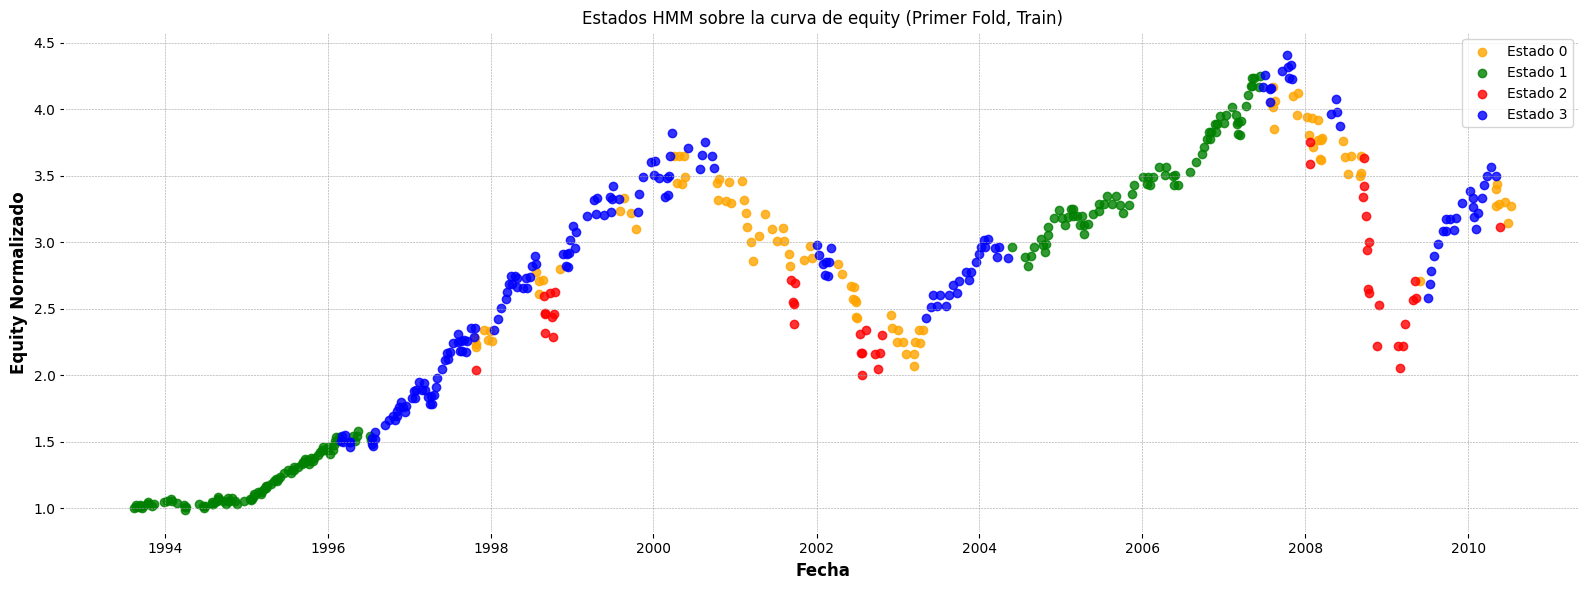

In [ ]:
# --- Selecciona el primer fold ---
i_fold = 0  # Primer fold
idx_tr, _ = folds[i_fold]
model = hmm_models[i_fold]

# --- Extrae precios, fechas y calcula equity ---
fechas_tr = pd.to_datetime(df_train.loc[idx_tr, 'Fecha_Cierre'])
precios_tr = df_train.loc[idx_tr, 'Precio_Cierre'].values
equity_tr = precios_tr / precios_tr[0]

# --- Predice los estados en train ---
X_tr = df_train.loc[idx_tr, features].values
estados_tr = model.predict(X_tr)

# --- Configuración de colores por estado ---
colores = ['orange', 'green', 'red', 'blue']

plt.figure(figsize=(16, 6))

for estado in np.unique(estados_tr):
    mask = (estados_tr == estado)
    plt.scatter(fechas_tr[mask], equity_tr[mask],
                label=f"Estado {estado}",
                color=colores[estado % len(colores)],
                s=36, alpha=0.8)

plt.title('Estados HMM sobre la curva de equity (Primer Fold, Train)')
plt.xlabel('Fecha')
plt.ylabel('Equity Normalizado')
plt.legend()
plt.tight_layout()
plt.show()

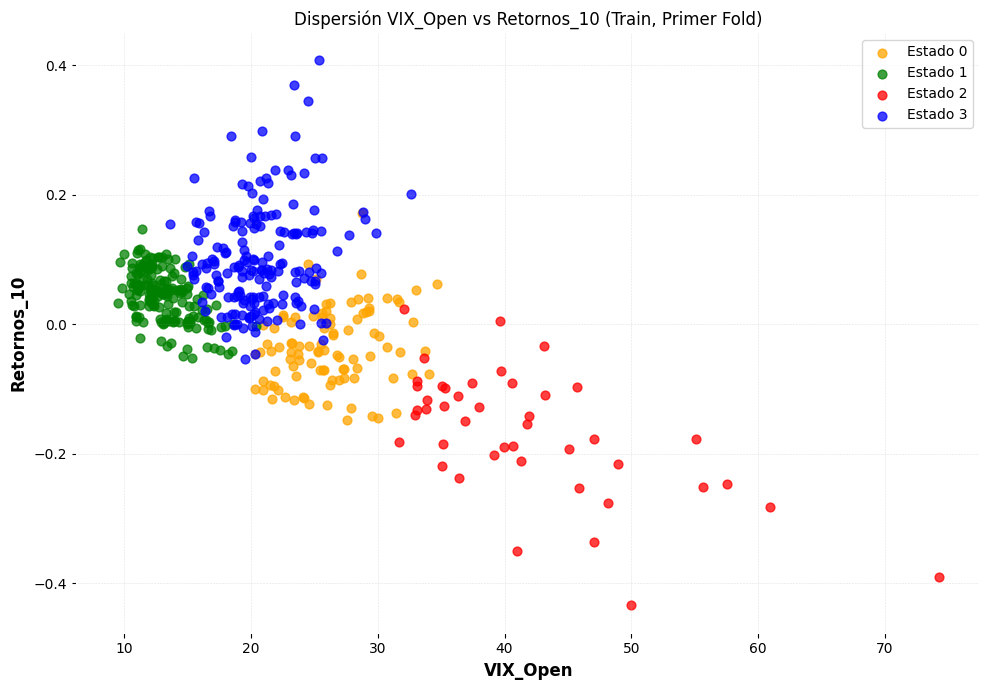

In [ ]:
# --- Selecciona el primer fold ---
i_fold = 0
idx_tr, _ = folds[i_fold]
model = hmm_models[i_fold]

# --- Extrae las variables y los estados ---
X_tr = df_train.loc[idx_tr, features].values
estados_tr = model.predict(X_tr)
vix_tr = X_tr[:, features.index('VIX_Open')]
ret10_tr = X_tr[:, features.index('Retornos_10')]

# --- Configuración de colores por estado ---
colores = ['orange', 'green', 'red', 'blue']

plt.figure(figsize=(10, 7))
for estado in np.unique(estados_tr):
    mask = (estados_tr == estado)
    plt.scatter(vix_tr[mask], ret10_tr[mask],
                label=f"Estado {estado}",
                color=colores[estado % len(colores)],
                s=40, alpha=0.75)

plt.xlabel('VIX_Open')
plt.ylabel('Retornos_10')
plt.title('Dispersión VIX_Open vs Retornos_10 (Train, Primer Fold)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Nueva variable categórica

# Asegura tener tu función de métricas económicas
def calcular_metricas_equity(equity, fechas):
    """
    Retorna (CAGR, Sharpe, Sortino, MDD, Calmar)
    """
    equity = np.array(equity)
    fechas = pd.to_datetime(fechas)
    start, end = fechas[0], fechas[-1]
    years = (end - start).days / 365.25
    if years <= 0: years = 1/365.25
    rets = pd.Series(equity).pct_change().dropna()
    mean_ret = rets.mean()
    std_ret  = rets.std(ddof=0)
    sharpe   = (mean_ret / std_ret) * np.sqrt(len(rets) / years) if std_ret > 0 else np.nan
    neg_rets = rets[rets < 0]
    sortino  = (mean_ret / neg_rets.std(ddof=0)) * np.sqrt(len(rets) / years) if len(neg_rets) > 0 else np.nan
    cagr = (equity[-1] / equity[0]) ** (1/years) - 1
    running_max = np.maximum.accumulate(equity)
    drawdowns = equity / running_max - 1
    mdd = drawdowns.min()
    calmar = cagr / abs(mdd) if mdd < 0 else np.nan
    return cagr, sharpe, sortino, mdd, calmar

# Asume que ya tienes folds, hmm_models, y df_train definidos

features = ['VIX_Open', 'Retornos_10']

for i, ((idx_tr, _), model) in enumerate(zip(folds, hmm_models), start=1):
    # 1. Extraer medias y std de cada estado
    means = model.means_
    raw_covars = model.covars_
    if raw_covars.ndim == 3:
        covars = np.array([np.diag(c) for c in raw_covars])
    else:
        covars = raw_covars
    stds = np.sqrt(covars)
    n_states = means.shape[0]

    # 2. Predecir estados en la parte de train
    X_tr = df_train.loc[idx_tr, features].values
    train_states = model.predict(X_tr)
    fechas_tr = df_train.loc[idx_tr, 'Fecha_Cierre']
    precios_tr = df_train.loc[idx_tr, 'Precio_Cierre']

    # 3. Calmar Ratio BH en todo el train
    equity_bh = precios_tr.values / precios_tr.iloc[0]
    _, _, _, _, calmar_bh = calcular_metricas_equity(equity_bh, fechas_tr.values)

    # 4. Calmar Ratio por estado
    estado_calmars = []
    for estado in range(n_states):
        mask = (train_states == estado)
        if mask.sum() < 2:
            calmar = np.nan
        else:
            precios_estado = precios_tr.values[mask]
            fechas_estado = fechas_tr.values[mask]
            equity_estado = precios_estado / precios_estado[0]
            _, _, _, _, calmar = calcular_metricas_equity(equity_estado, fechas_estado)
        estado_calmars.append(calmar)
    estado_calmars = np.array(estado_calmars)

    # 5. Seleccionar hasta los 2 mejores estados por Calmar Ratio (debe ser mayor que el BH)
    # Ordenar por Calmar descendente, filtrar > calmar_bh
    idx_sort = np.argsort(estado_calmars)[::-1]
    mejores_estados = [idx for idx in idx_sort if not np.isnan(estado_calmars[idx]) and estado_calmars[idx] > calmar_bh][:2]

    print(f"Fold {i}: Estados favorables (máx 2, Calmar > BH): {mejores_estados}")

    # 6. Construir condición booleana compuesta
    mask_favorable = np.zeros(len(df_train), dtype=bool)
    for estado in mejores_estados:
        mean_r10 = means[estado, features.index('Retornos_10')]
        std_r10  = stds[estado, features.index('Retornos_10')]
        mean_vix = means[estado, features.index('VIX_Open')]
        std_vix  = stds[estado, features.index('VIX_Open')]

        cond = (
            (df_train['Retornos_10'] > (mean_r10 - std_r10)) &
            (df_train['VIX_Open']    < (mean_vix + std_vix))
        )
        mask_favorable |= cond

    col_new = f'HMM_cond_fold_{i}'
    df_train[col_new] = mask_favorable.astype(int)
    print(f"Columna '{col_new}' creada para Fold {i}.")

Fold 1: Estados favorables (máx 2, Calmar > BH): [np.int64(1), np.int64(3)]
Columna 'HMM_cond_fold_1' creada para Fold 1.
Fold 2: Estados favorables (máx 2, Calmar > BH): [np.int64(0), np.int64(2)]
Columna 'HMM_cond_fold_2' creada para Fold 2.
Fold 3: Estados favorables (máx 2, Calmar > BH): [np.int64(1), np.int64(3)]
Columna 'HMM_cond_fold_3' creada para Fold 3.
Fold 4: Estados favorables (máx 2, Calmar > BH): [np.int64(1), np.int64(3)]
Columna 'HMM_cond_fold_4' creada para Fold 4.
Fold 5: Estados favorables (máx 2, Calmar > BH): [np.int64(0), np.int64(2)]
Columna 'HMM_cond_fold_5' creada para Fold 5.
Fold 6: Estados favorables (máx 2, Calmar > BH): [np.int64(1), np.int64(3)]
Columna 'HMM_cond_fold_6' creada para Fold 6.
Fold 7: Estados favorables (máx 2, Calmar > BH): [np.int64(0), np.int64(1)]
Columna 'HMM_cond_fold_7' creada para Fold 7.
Fold 8: Estados favorables (máx 2, Calmar > BH): [np.int64(2), np.int64(1)]
Columna 'HMM_cond_fold_8' creada para Fold 8.
Fold 9: Estados favorabl

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Fecha_Cierre      900 non-null    datetime64[ns]
 1   Precio_Cierre     900 non-null    float64       
 2   Volume            900 non-null    float64       
 3   ATR20             900 non-null    float64       
 4   TP                900 non-null    float64       
 5   SL                900 non-null    float64       
 6   Retorno_pct       900 non-null    float64       
 7   Objetivo          900 non-null    int64         
 8   VIX_Open          900 non-null    float64       
 9   Retornos_10       900 non-null    float64       
 10  HMM_cond_fold_1   900 non-null    int64         
 11  HMM_cond_fold_2   900 non-null    int64         
 12  HMM_cond_fold_3   900 non-null    int64         
 13  HMM_cond_fold_4   900 non-null    int64         
 14  HMM_cond_fold_5   900 non-

In [ ]:
# Mostrar las columnas VIX_Open, Retornos_10 y HMM_cond_fold_10
df_train[['VIX_Open', 'Retornos_10', 'HMM_cond_fold_10']].tail(10)

,VIX_Open,Retornos_10,HMM_cond_fold_10
890,27.500000,-0.082177,1
891,31.370001,-0.118047,1
892,24.070000,-0.102749,1
893,22.129999,-0.027872,1
894,20.340000,-0.035422,1
895,22.410000,-0.019339,1
896,26.860001,-0.015349,1
897,25.459999,-0.083448,1
898,23.490000,-0.009699,1
899,26.100000,0.005914,1


# 4. Modelado y Backtest

In [ ]:
from xgboost import XGBClassifier

xgb_params = {
    'learning_rate':     0.1,
    'n_estimators':      150,
    'max_depth':         4,
    'min_child_weight':  2,
    'subsample':         0.8,
    'colsample_bytree':  0.8,
    'gamma':             0.1,
    'reg_alpha':         0.1,
    'reg_lambda':        1.5,
    'use_label_encoder': False,
    'eval_metric':       'logloss',
    'random_state':      42
}
threshold = 0.45
capital_inicial      = 100_000.0
riesgo_pct           = 0.02
spread               = 0.01
comision_por_accion  = 0.001

static_feats = ['VIX_Open','Retornos_10']
df_train["Señal"] = np.nan
df_train["Probabilidad_Señal"] = np.nan

metrics      = []
df_global_bt = pd.DataFrame()

for i, (idx_tr, idx_va) in enumerate(folds, start=1):
    cond_col = f'HMM_cond_fold_{i}'
    feats = static_feats + [cond_col]

    # -- Preparar datos de entrenamiento y validación --
    df_tr = df_train.loc[idx_tr, feats + ['Objetivo']].copy()
    df_tr = pd.get_dummies(df_tr, columns=[cond_col], prefix=f'HMM_c{i}')
    X_tr = df_tr.drop(columns='Objetivo')
    y_tr = df_tr['Objetivo']

    model = XGBClassifier(**xgb_params)
    model.fit(X_tr, y_tr)

    df_val = df_train.loc[idx_va, feats + ['Objetivo','Precio_Cierre','SL','Fecha_Cierre']].copy()
    df_val = pd.get_dummies(df_val, columns=[cond_col], prefix=f'HMM_c{i}')
    for col in X_tr.columns:
        if col not in df_val.columns:
            df_val[col] = 0
    X_va = df_val[X_tr.columns]
    y_prob = model.predict_proba(X_va)[:,1]
    y_pred = (y_prob >= threshold).astype(int)
    df_val['Signal'] = y_pred

    # === Asignar la señal y la probabilidad al dataframe principal ===
    df_train.loc[idx_va, "Señal"] = y_pred
    df_train.loc[idx_va, "Probabilidad_Señal"] = y_prob

    # === Backtest realista ===
    df_bt = ejecutar_backtest(df_val, signal_col='Signal',
                             capital_inicial=capital_inicial,
                             riesgo_pct=riesgo_pct,
                             spread=spread,
                             comision_por_accion=comision_por_accion)

    # === Métricas fold ===
    equity = df_bt['Equity']
    fechas = pd.to_datetime(df_bt['Fecha_Cierre'])
    anios = (fechas.iloc[-1] - fechas.iloc[0]).days / 365.25
    if anios <= 0:
        anios = 1/365.25  # Evitar división por cero

    total_ret = equity.iloc[-1]/equity.iloc[0] - 1
    cagr = (equity.iloc[-1] / equity.iloc[0])**(1/anios) - 1
    running_max = equity.cummax()
    drawdowns = equity / running_max - 1
    mdd = drawdowns.min()
    calmar = cagr / abs(mdd) if mdd < 0 else np.nan
    tuw = (equity < running_max).mean()

    # --- Métricas sobre trades ejecutados ---
    df_trades = df_bt[df_bt['Shares'] > 0]
    num_trades = len(df_trades)
    if num_trades > 0:
        hit_rate = (df_trades['NetPnL'] > 0).mean()
        wins = df_trades.loc[df_trades['NetPnL'] > 0, 'NetPnL'].sum()
        loses = -df_trades.loc[df_trades['NetPnL'] < 0, 'NetPnL'].sum()
        profit_factor = wins / loses if loses > 0 else np.nan
    else:
        hit_rate = np.nan
        profit_factor = np.nan

    # -- Sharpe y Sortino del equity curve (sobre todos los eventos, para referencia) --
    rets = df_bt['NetPnL'] / equity.iloc[0]
    mean_ret = rets.mean()
    std_ret = rets.std(ddof=0)
    events_per_year = len(rets) / anios
    sharpe = (mean_ret / std_ret) * np.sqrt(events_per_year) if std_ret > 0 else np.nan
    neg_rets = rets[rets < 0]
    sortino = (mean_ret / neg_rets.std(ddof=0)) * np.sqrt(events_per_year) if len(neg_rets) > 0 else np.nan

    metrics.append({
        'fold':         i,
        'TotalRet':     total_ret,
        'CAGR':         cagr,
        'Sharpe':       sharpe,
        'Sortino':      sortino,
        'MDD':          mdd,
        'Calmar':       calmar,
        'NumTrades':    num_trades,
        'HitRate':      hit_rate,
        'ProfitFactor': profit_factor,
        'TUW':          tuw
    })

    df_global_bt = pd.concat([df_global_bt, df_bt], axis=0)

df_metrics = pd.DataFrame(metrics).set_index('fold')
print("=== Métricas por Fold ===")
print(df_metrics[['TotalRet','CAGR','Sharpe','Sortino','MDD','Calmar','NumTrades','HitRate','ProfitFactor','TUW']])

# Guardar métricas por fold a Excel
df_metrics.to_excel('metricas_xgboost_por_fold.xlsx')

# --- MÉTRICAS GLOBALES (estrategia) ---
dfg = df_global_bt.sort_values('Fecha_Cierre').copy()
dfg['Equity_global'] = capital_inicial + dfg['NetPnL'].cumsum()


# --- Cálculo de exposición promedio ---
# Exposición monetaria: Shares * EntryPrice en cada evento, 0 si no hay operación
dfg['Exposicion'] = dfg['Shares'] * dfg['EntryPrice']
# Exposición promedio sobre todos los eventos (incluidos los de exposición 0)
exposicion_prom_g = dfg['Exposicion'].mean()
exposicion_prom_pct = exposicion_prom_g / capital_inicial  # % sobre el capital inicial

equity_g    = dfg['Equity_global']
start_g     = pd.to_datetime(dfg['Fecha_Cierre'].iloc[0])
end_g       = pd.to_datetime(dfg['Fecha_Cierre'].iloc[-1])
years_g     = (end_g - start_g).days / 365.25 or (1/365.25)
total_ret_g = equity_g.iloc[-1] / equity_g.iloc[0] - 1
rets_g            = equity_g.pct_change().dropna()
events_per_year_g = len(rets_g) / years_g
mean_ret_g        = rets_g.mean()
std_ret_g         = rets_g.std(ddof=0)
sharpe_g          = (mean_ret_g / std_ret_g) * np.sqrt(events_per_year_g) if std_ret_g>0 else np.nan
neg_rets_g        = rets_g[rets_g < 0]
sortino_g         = (mean_ret_g / neg_rets_g.std(ddof=0)) * np.sqrt(events_per_year_g) if len(neg_rets_g)>0 else np.nan
cagr_g        = (equity_g.iloc[-1] / equity_g.iloc[0])**(1/years_g) - 1
running_max_g = equity_g.cummax()
drawdowns_g   = equity_g / running_max_g - 1
mdd_g         = drawdowns_g.min()
calmar_g      = cagr_g / abs(mdd_g) if mdd_g<0 else np.nan
df_trades_g      = dfg[dfg['Shares'] > 0]
hit_rate_g       = (df_trades_g['NetPnL'] > 0).mean()
wins_g           = df_trades_g['NetPnL'][df_trades_g['NetPnL']>0].sum()
loses_g          = -df_trades_g['NetPnL'][df_trades_g['NetPnL']<0].sum()
profit_factor_g  = wins_g / loses_g if loses_g>0 else np.nan
tuw_g            = (equity_g < running_max_g).mean()

# --- Eficiencia del capital ---
eficiencia_capital = cagr_g / exposicion_prom_pct if exposicion_prom_pct > 0 else np.nan

print("\n=== Métricas Globales ===")
print(f"Total Return global      : {total_ret_g:.2%}")
print(f"CAGR global              : {cagr_g:.2%}")
print(f"Sharpe global            : {sharpe_g:.2f}")
print(f"Sortino global           : {sortino_g:.2f}")
print(f"MDD global               : {mdd_g:.2f}")
print(f"Calmar global            : {calmar_g:.2f}")
print(f"Hit-Rate global          : {hit_rate_g:.2%}")
print(f"Profit Factor global     : {profit_factor_g:.2f}")
print(f"Time Under Water global  : {tuw_g:.2%}")
print(f"\n--- Exposición Promedio del Capital ---")
print(f"Exposición promedio      : ${exposicion_prom_g:,.2f} ({exposicion_prom_pct:.2%} del capital inicial)")
print(f"Eficiencia del capital   : {eficiencia_capital:.2%}")

# Guardar resultados globales en un nuevo DataFrame y a Excel
resultados_globales = pd.DataFrame({
    'TotalRet_global': [total_ret_g],
    'CAGR_global': [cagr_g],
    'Sharpe_global': [sharpe_g],
    'Sortino_global': [sortino_g],
    'MDD_global': [mdd_g],
    'Calmar_global': [calmar_g],
    'HitRate_global': [hit_rate_g],
    'ProfitFactor_global': [profit_factor_g],
    'TUW_global': [tuw_g],
    'Exposicion_promedio': [exposicion_prom_g],
    'Exposicion_promedio_pct': [exposicion_prom_pct],
    'Eficiencia_capital': [eficiencia_capital]
})

resultados_globales.to_excel('metricas_xgboost_global.xlsx', index=False)

=== Métricas por Fold ===
      TotalRet      CAGR    Sharpe     Sortino       MDD    Calmar  NumTrades  \
fold                                                                            
1     0.100745  0.097187  0.918225   39.482615 -0.054471  1.784190         29   
2     0.103864  0.080173  0.851237  150.711890 -0.069044  1.161199         29   
3     0.192130  0.150802  1.883564    8.460100 -0.044172  3.413959         27   
4     0.089351  0.072266  0.909757   16.220796 -0.056805  1.272164         29   
5     0.184763  0.115403  1.755043   21.320271 -0.039221  2.942415         24   
6     0.242495  0.259272  2.514733 2790.066831 -0.037393  6.933739         28   
7     0.068760  0.057425  0.162394    0.405104 -0.061512  0.933558         26   
8     0.079338  0.096069  0.849644    2.899563 -0.101648  0.945117         33   
9     0.205001  0.199173  2.114067 6258.799081 -0.085711  2.323770         28   
10   -0.069106 -0.053796 -0.355840   -1.484520 -0.125195 -0.429698         33   

 

**Buy and Hold**

In [ ]:
# --- Función auxiliar para métricas ---
def calcular_metricas(equity_curve, fechas, capital_inicial, include_sortino):
    """
    equity_curve: array-like de equity a lo largo del tiempo
    fechas: pd.Series de datetime correspondiente a cada punto de equity_curve
    capital_inicial: float
    include_sortino: bool, si True devuelve también sortino
    Retorna:
      if include_sortino:
         (cagr, sharpe, sortino, mdd)
      else:
         (cagr, sharpe, mdd)
    """
    # Asegurar numpy array
    equity = np.array(equity_curve)
    # Horizon en años calendario
    fechas = pd.to_datetime(fechas)
    start, end = fechas.iloc[0], fechas.iloc[-1]
    years = (end - start).days / 365.25
    if years <= 0:
        years = 1/365.25  # al menos un día

    # Retornos periódicos
    rets = pd.Series(equity).pct_change().dropna()
    events_per_year = len(rets) / years

    mean_ret = rets.mean()
    std_ret  = rets.std(ddof=0)
    sharpe   = (mean_ret / std_ret) * np.sqrt(events_per_year) if std_ret > 0 else np.nan

    # Sortino si se pide
    if include_sortino:
        neg_rets = rets[rets < 0]
        sortino  = (mean_ret / neg_rets.std(ddof=0)) * np.sqrt(events_per_year) if len(neg_rets) > 0 else np.nan
    else:
        sortino = None

    # CAGR anualizado
    cagr = (equity[-1] / equity[0]) ** (1/years) - 1

    # Drawdown y MDD (negativo)
    running_max = np.maximum.accumulate(equity)
    drawdowns   = equity / running_max - 1
    mdd         = drawdowns.min()

    if include_sortino:
        return cagr, sharpe, sortino, mdd
    else:
        return cagr, sharpe, mdd

# --- Parámetros Buy & Hold ---
capital_inicial = 100_000

# --- 1) Buy & Hold por fold con todas las métricas ---
resultados_bh = []

for i, (_, idx_test) in enumerate(folds, start=1):
    fechas_fold = df_barras.loc[idx_test, "Fecha_Cierre"]
    start, end  = fechas_fold.iloc[0], fechas_fold.iloc[-1]
    precios     = df.loc[start:end, "Close"]

    if len(precios) < 2:
        resultados_bh.append({
            "fold":         i,
            "TotalRet":     0.0,
            "CAGR":         0.0,
            "Sharpe":       0.0,
            "Sortino":      0.0,
            "MDD":          0.0,
            "Calmar":       0.0,
            "HitRate":      0.0,
            "ProfitFactor": 0.0,
            "TUW":          0.0
        })
        continue

    # Equity curve
    equity_bh = capital_inicial * (precios.values / precios.iloc[0])

    # Métricas (incluyendo Sortino y MDD negativo)
    cagr_bh, sharpe_bh, sortino_bh, mdd_bh = calcular_metricas(
        equity_curve=equity_bh,
        fechas=pd.Series(precios.index),
        capital_inicial=capital_inicial,
        include_sortino=True
    )

    # Calmar Ratio
    calmar_bh = cagr_bh / abs(mdd_bh) if mdd_bh < 0 else np.nan

    # HitRate, ProfitFactor, TUW
    rets = pd.Series(equity_bh).pct_change().dropna()
    hit_rate_bh  = (rets > 0).mean()
    wins_bh      = rets[rets > 0].sum()
    loses_bh     = -rets[rets < 0].sum()
    pf_bh        = wins_bh / loses_bh if loses_bh > 0 else np.nan
    tuw_bh       = (pd.Series(equity_bh) < pd.Series(equity_bh).cummax()).mean()

    resultados_bh.append({
        "fold":         i,
        "TotalRet":     equity_bh[-1]/equity_bh[0] - 1,
        "CAGR":         cagr_bh,
        "Sharpe":       sharpe_bh,
        "Sortino":      sortino_bh,
        "MDD":          mdd_bh,
        "Calmar":       calmar_bh,
        "HitRate":      hit_rate_bh,
        "ProfitFactor": pf_bh,
        "TUW":          tuw_bh
    })

df_bh = pd.DataFrame(resultados_bh).set_index("fold")
pd.set_option('display.float_format', '{:.4f}'.format)

print("=== Buy & Hold: métricas por fold ===")
print(df_bh)

# Guardar métricas por fold en Excel
df_bh.to_excel('metricas_buyhold_por_fold.xlsx')

# --- Resumen agregado ---
mean_bh = df_bh.mean()
mdd_min = df_bh["MDD"].min()

# Guardar resumen agregado en Excel
resumen_bh = pd.DataFrame(mean_bh).T
resumen_bh['MDD_mas_negativo'] = mdd_min
resumen_bh.to_excel('metricas_buyhold_resumen.xlsx', index=False)

print("\n=== Buy & Hold: resumen agregado ===")
print(f"  TotalRet promedio   : {mean_bh['TotalRet']:.2%}")
print(f"  CAGR promedio       : {mean_bh['CAGR']:.2%}")
print(f"  Sharpe promedio     : {mean_bh['Sharpe']:.2f}")
print(f"  Sortino promedio    : {mean_bh['Sortino']:.2f}")
print(f"  MDD más negativo    : {mdd_min:.2%}")
print(f"  Calmar promedio     : {mean_bh['Calmar']:.2f}")
print(f"  HitRate promedio    : {mean_bh['HitRate']:.2%}")
print(f"  ProfitFactor medio  : {mean_bh['ProfitFactor']:.2f}")
print(f"  TUW promedio        : {mean_bh['TUW']:.2%}")

# --- 2) Buy & Hold global (con Sortino y todas las métricas) ---
all_dates    = pd.concat([ df_barras.loc[idx, "Fecha_Cierre"] for _, idx in folds ])
global_start = all_dates.min()
global_end   = all_dates.max()

precios_glob = df.loc[global_start:global_end, "Close"]

if len(precios_glob) < 2:
    cagr_g = sharpe_g = sortino_g = mdd_g = 0.0
    total_ret_g = hit_rate_g = pf_g = tuw_g = calmar_g = np.nan
else:
    equity_glob = capital_inicial * (precios_glob.values / precios_glob.iloc[0])
    fechas_glob = pd.Series(precios_glob.index)

    cagr_g, sharpe_g, sortino_g, mdd_g = calcular_metricas(
        equity_curve=equity_glob,
        fechas=fechas_glob,
        capital_inicial=capital_inicial,
        include_sortino=True
    )
    total_ret_g = equity_glob[-1]/equity_glob[0] - 1
    calmar_g    = cagr_g / abs(mdd_g) if mdd_g < 0 else np.nan

    rets_g     = pd.Series(equity_glob).pct_change().dropna()
    hit_rate_g = (rets_g > 0).mean()
    wins_g     = rets_g[rets_g > 0].sum()
    loses_g    = -rets_g[rets_g < 0].sum()
    pf_g       = wins_g / loses_g if loses_g > 0 else np.nan
    tuw_g      = (pd.Series(equity_glob) < pd.Series(equity_glob).cummax()).mean()

print("\n=== Buy & Hold: métricas globales ===")
print(f"  TotalRet       : {total_ret_g:.2%}")
print(f"  CAGR           : {cagr_g:.4f}")
print(f"  Sharpe         : {sharpe_g:.2f}")
print(f"  Sortino        : {sortino_g:.2f}")
print(f"  MDD            : {mdd_g:.2f}")   # negativo
print(f"  Calmar         : {calmar_g:.2f}")
print(f"  HitRate        : {hit_rate_g:.2%}")
print(f"  ProfitFactor   : {pf_g:.2f}")
print(f"  TUW            : {tuw_g:.2%}")

# Guardar resultados globales en Excel
resultados_bh_global = pd.DataFrame({
    'TotalRet_global': [total_ret_g],
    'CAGR_global': [cagr_g],
    'Sharpe_global': [sharpe_g],
    'Sortino_global': [sortino_g],
    'MDD_global': [mdd_g],
    'Calmar_global': [calmar_g],
    'HitRate_global': [hit_rate_g],
    'ProfitFactor_global': [pf_g],
    'TUW_global': [tuw_g]
})
resultados_bh_global.to_excel('metricas_buyhold_global.xlsx', index=False)

=== Buy & Hold: métricas por fold ===
      TotalRet    CAGR  Sharpe  Sortino     MDD  Calmar  HitRate  \
fold                                                               
1       0.1308  0.1254  0.8845   1.1393 -0.1142  1.0990   0.5492   
2       0.1896  0.1438  0.7563   0.9879 -0.0969  1.4842   0.5494   
3       0.3396  0.2582  2.0853   2.9636 -0.0570  4.5323   0.5719   
4       0.1402  0.1101  0.9689   1.3787 -0.0727  1.5133   0.5538   
5       0.1450  0.0885  0.6553   0.8580 -0.1302  0.6799   0.5236   
6       0.2016  0.2092  2.6167   3.2347 -0.0388  5.3877   0.5738   
7       0.1166  0.0923  0.6379   0.8084 -0.1935  0.4771   0.5510   
8      -0.1331 -0.1549 -0.4571  -0.4329 -0.2911 -0.5322   0.5607   
9       0.5552  0.4952  2.2565   2.9181 -0.0944  5.2451   0.5921   
10     -0.0530 -0.0407 -0.1162  -0.1547 -0.2301 -0.1767   0.5196   

      ProfitFactor    TUW  
fold                       
1           1.1657 0.7811  
2           1.1485 0.8585  
3           1.4103 0.7383  
4    

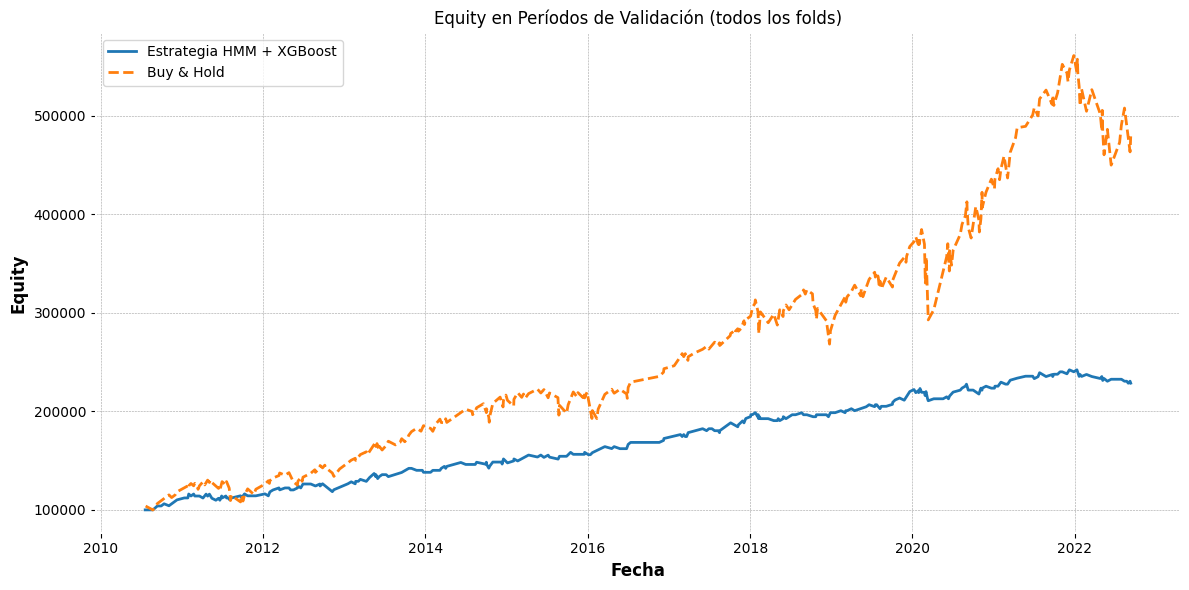

In [ ]:
# Ordenar por fecha y calcular equity acumulada de la estrategia
df_plot = df_global_bt.sort_values('Fecha_Cierre').copy()
df_plot['Equity_strategy'] = capital_inicial + df_plot['NetPnL'].cumsum()

# Calcular equity Buy & Hold sobre ese mismo período
prices = df_plot['Precio_Cierre']
rets   = prices.pct_change().dropna()
equity_bh = capital_inicial * (1 + rets).cumprod()
dates_bh  = df_plot['Fecha_Cierre'].iloc[1:]  # alinea con rets

# Graficar comparativo
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_plot['Fecha_Cierre'], df_plot['Equity_strategy'],
        label='Estrategia HMM + XGBoost', linewidth=2)
ax.plot(dates_bh, equity_bh,
        label='Buy & Hold', linestyle='--', linewidth=2)

ax.set_title('Equity en Períodos de Validación (todos los folds)')
ax.set_xlabel('Fecha')
ax.set_ylabel('Equity')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df_metrics_bh = df_bh[['CAGR','Sharpe','Sortino','Calmar','HitRate']].copy()

# --- 2) Ahora compara fold a fold ---
metrics = ['CAGR','Sharpe', 'Sortino', 'Calmar', 'HitRate']
comp = pd.DataFrame(index=metrics, columns=['Wins', 'TotalFolds', 'Pct_Estrategia>BH'])

total_folds = len(df_metrics)

for m in metrics:
    wins = (df_metrics[m] > df_bh[m]).sum()
    comp.loc[m, 'Wins']              = wins
    comp.loc[m, 'TotalFolds']        = total_folds
    comp.loc[m, 'Pct_Estrategia>BH'] = wins / total_folds * 100

# Formatear el porcentaje como número (para Excel), pero también como string si lo prefieres
comp['Pct_Estrategia>BH'] = comp['Pct_Estrategia>BH'].astype(float)
comp_formatted = comp.copy()
comp_formatted['Pct_Estrategia>BH'] = comp_formatted['Pct_Estrategia>BH'].map("{:.1f}%".format)

print("\nComparación fold a fold de Estrategia vs Buy & Hold:")
print(comp_formatted)

# Guardar tabla en Excel
comp.to_excel('comparacion_estrategia_vs_buyhold.xlsx')


Comparación fold a fold de Estrategia vs Buy & Hold:
        Wins TotalFolds Pct_Estrategia>BH
CAGR       3         10             30.0%
Sharpe     4         10             40.0%
Sortino    8         10             80.0%
Calmar     5         10             50.0%
HitRate    8         10             80.0%


**Crear una columna con el resultado real de la señal**

In [ ]:
# Asume que df_train['Señal'] ya está lleno.
# Resultado_Señal: 1 si la operación fue exitosa (Precio_Cierre siguiente > actual), 0 si no, np.nan si no hubo señal
df_train["Resultado_Señal"] = np.where(
    (df_train["Señal"] == 1) & (df_train["Precio_Cierre"].shift(-1) > df_train["Precio_Cierre"]),
    1,
    np.where((df_train["Señal"] == 1) & (df_train["Precio_Cierre"].shift(-1) <= df_train["Precio_Cierre"]), 0, np.nan)
)

**Analizar la relación probabilidad vs resultado**

                   count   mean    std    min    25%    50%    75%    max
Resultado_Señal                                                          
0.0000          113.0000 0.6623 0.1092 0.4565 0.5782 0.6490 0.7386 0.9411
1.0000          178.0000 0.6408 0.1138 0.4506 0.5411 0.6418 0.7215 0.9304


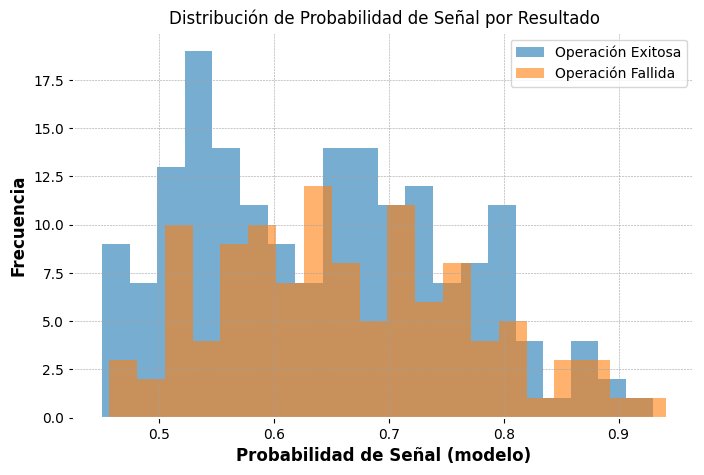

AUC (probabilidad de señal vs resultado): 0.445


In [ ]:
# Extrae sólo las filas con señales activas y resultado disponible
df_senal = df_train[df_train['Señal'] == 1].copy()
df_senal = df_senal[df_senal['Resultado_Señal'].notna()]

# Tabla: promedios de probabilidad según éxito
print(df_senal.groupby('Resultado_Señal')['Probabilidad_Señal'].describe())

# Gráfica: histogramas de probabilidad por resultado
plt.figure(figsize=(8,5))
plt.hist(df_senal.loc[df_senal['Resultado_Señal']==1, 'Probabilidad_Señal'], bins=20, alpha=0.6, label='Operación Exitosa')
plt.hist(df_senal.loc[df_senal['Resultado_Señal']==0, 'Probabilidad_Señal'], bins=20, alpha=0.6, label='Operación Fallida')
plt.xlabel('Probabilidad de Señal (modelo)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Probabilidad de Señal por Resultado')
plt.legend()
plt.show()

# (Opcional) Calcular AUC para discriminar resultados usando la probabilidad:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(df_senal['Resultado_Señal'], df_senal['Probabilidad_Señal'])
print(f"AUC (probabilidad de señal vs resultado): {auc:.3f}")

        prob_bin  Promedio_Probabilidad  Tasa_Éxito  Cantidad_Senales
0  (-0.001, 0.1]                    NaN         NaN                 0
1     (0.1, 0.2]                    NaN         NaN                 0
2     (0.2, 0.3]                    NaN         NaN                 0
3     (0.3, 0.4]                    NaN         NaN                 0
4     (0.4, 0.5]                 0.4728      0.8000                20
5     (0.5, 0.6]                 0.5475      0.6304                92
6     (0.6, 0.7]                 0.6531      0.5926                81
7     (0.7, 0.8]                 0.7447      0.5821                67
8     (0.8, 0.9]                 0.8393      0.5714                28
9     (0.9, 1.0]                 0.9248      0.3333                 3


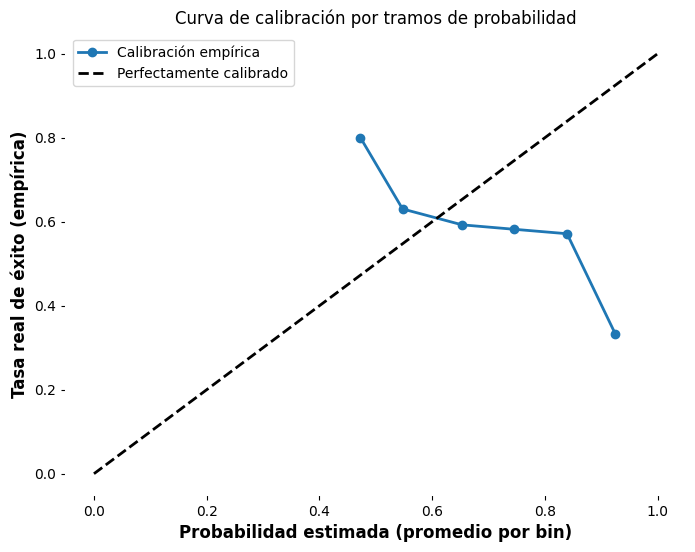

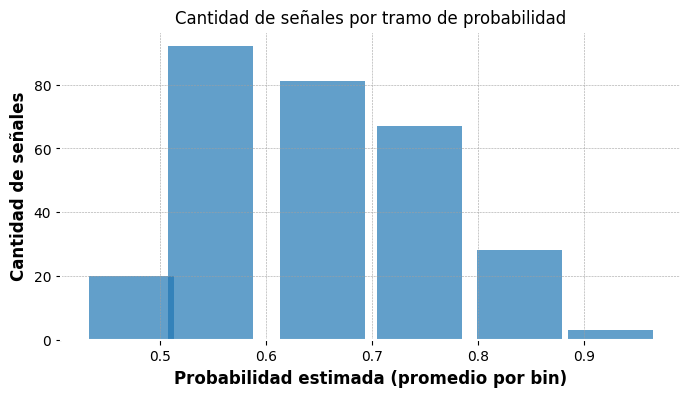

In [ ]:
# Parámetros: cantidad de bins (puedes ajustar)
n_bins = 10

# Crea los bins
df_senal['prob_bin'] = pd.cut(df_senal['Probabilidad_Señal'], bins=np.linspace(0, 1, n_bins+1), include_lowest=True)

# Calcula métrica por bin
calibration = df_senal.groupby('prob_bin').agg(
    Promedio_Probabilidad=('Probabilidad_Señal', 'mean'),
    Tasa_Éxito=('Resultado_Señal', 'mean'),
    Cantidad_Senales=('Resultado_Señal', 'count')
).reset_index()

print(calibration)

# Gráfica: calibración
plt.figure(figsize=(8,6))
plt.plot(calibration['Promedio_Probabilidad'], calibration['Tasa_Éxito'], 'o-', label='Calibración empírica')
plt.plot([0,1], [0,1], 'k--', label='Perfectamente calibrado')
plt.xlabel('Probabilidad estimada (promedio por bin)')
plt.ylabel('Tasa real de éxito (empírica)')
plt.title('Curva de calibración por tramos de probabilidad')
plt.legend()
plt.grid()
plt.show()

# (Opcional) Histograma de la cantidad de señales por bin
plt.figure(figsize=(8,4))
plt.bar(calibration['Promedio_Probabilidad'], calibration['Cantidad_Senales'], width=0.08, alpha=0.7)
plt.xlabel('Probabilidad estimada (promedio por bin)')
plt.ylabel('Cantidad de señales')
plt.title('Cantidad de señales por tramo de probabilidad')
plt.show()

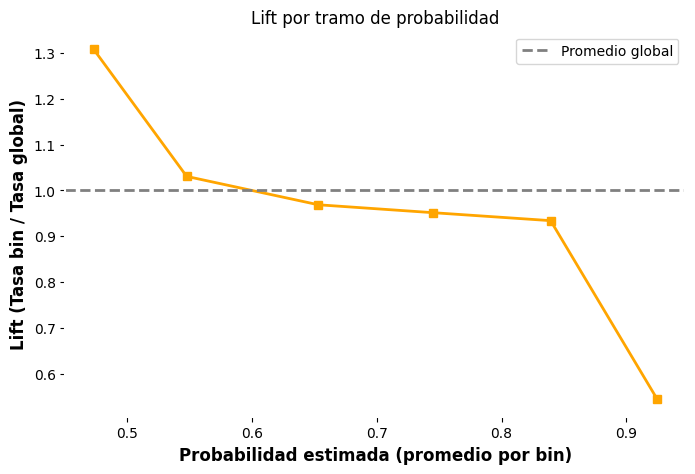

In [ ]:
tasa_global = df_senal['Resultado_Señal'].mean()
calibration['Lift'] = calibration['Tasa_Éxito'] / tasa_global

plt.figure(figsize=(8,5))
plt.plot(calibration['Promedio_Probabilidad'], calibration['Lift'], 's-', color='orange')
plt.axhline(1, color='grey', linestyle='--', label='Promedio global')
plt.xlabel('Probabilidad estimada (promedio por bin)')
plt.ylabel('Lift (Tasa bin / Tasa global)')
plt.title('Lift por tramo de probabilidad')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Usar 'Objetivo' como tasa de acierto potencial si se hubiera operado en todos los eventos descartados
eventos_señalizados = df_train[df_train['Señal'] == 1]
eventos_descartados = df_train[df_train['Señal'] == 0]

# Usar la variable 'Objetivo' como "acierto" potencial
tasa_acierto_señalizados   = eventos_señalizados['Objetivo'].mean()
tasa_acierto_descartados   = eventos_descartados['Objetivo'].mean()
cantidad_señalizados       = len(eventos_señalizados)
cantidad_descartados       = len(eventos_descartados)

print(f"Cantidad de eventos señalizados: {cantidad_señalizados}")
print(f"Cantidad de eventos descartados: {cantidad_descartados}")
print(f"Tasa de acierto (señalizados):   {tasa_acierto_señalizados:.2%}")
print(f"Tasa de acierto (descartados):   {tasa_acierto_descartados:.2%}")

Cantidad de eventos señalizados: 291
Cantidad de eventos descartados: 109
Tasa de acierto (señalizados):   61.17%
Tasa de acierto (descartados):   51.38%


**Señales Aleatorias 1000 Veces sobre Validación**

Resultados promedio de señales aleatorias (1000 simulaciones):
CAGR            0.0543
Sharpe          0.7534
Sortino         3.2598
MDD            -0.1193
Calmar          0.4912
HitRate         0.5860
ProfitFactor    1.3680
TUW             0.7922
dtype: float64

P-values (probabilidad de que la estrategia aleatoria iguale o supere a tu modelo):
CAGR:         0.025
Sharpe:       0.016
Sortino:      0.294
MDD:          0.001
Calmar:       0.002
HitRate:      0.032
ProfitFactor: 0.030
TUW:          0.035


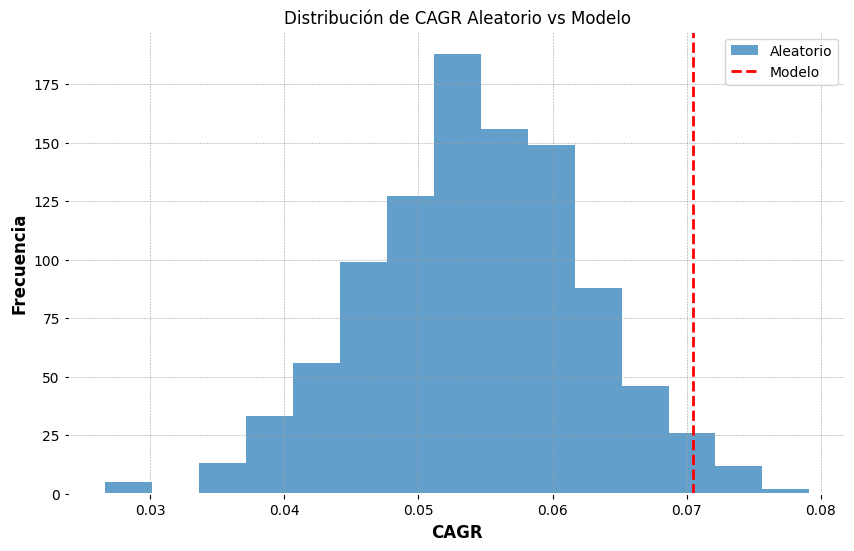

In [ ]:
# Asegúrate de tener estos parámetros definidos igual que en tu modelo real
capital_inicial      = 100_000.0
riesgo_pct           = 0.02
spread               = 0.01
comision_por_accion  = 0.001

# Limitar la muestra solo a las filas de validación (últimas 400 filas)
idx_val = df_train.index[-400:]

# Número de señales a simular (igual que las del modelo real en validación)
n_signals = int((df_train.loc[idx_val, 'Señal'] == 1).sum())

# Extraer una copia del DataFrame de validación
df_val = df_train.loc[idx_val].copy()

# Almacenar los resultados
metrics_list = ['CAGR','Sharpe','Sortino','MDD','Calmar','HitRate','ProfitFactor','TUW']
random_metrics = {k: [] for k in metrics_list}

n_simulaciones = 1000

for sim in range(n_simulaciones):
    np.random.seed(sim + 42)  # Distinto seed por simulación
    # Asignar señales aleatorias SOLO en la ventana de validación
    signal = np.zeros(len(df_val))
    random_idx = np.random.choice(df_val.index, size=n_signals, replace=False)
    signal[df_val.index.get_indexer(random_idx)] = 1
    df_val['Signal'] = signal

    # Backtest
    df_bt_random = ejecutar_backtest(
        df_val,
        signal_col='Signal',
        capital_inicial=capital_inicial,
        riesgo_pct=riesgo_pct,
        spread=spread,
        comision_por_accion=comision_por_accion
    )
    equity = df_bt_random['Equity']
    fechas = pd.to_datetime(df_bt_random['Fecha_Cierre'])
    anios = (fechas.iloc[-1] - fechas.iloc[0]).days / 365.25
    if anios <= 0: anios = 1/365.25

    cagr = (equity.iloc[-1] / equity.iloc[0])**(1/anios) - 1
    running_max = equity.cummax()
    drawdowns = equity / running_max - 1
    mdd = drawdowns.min()
    calmar = cagr / abs(mdd) if mdd < 0 else np.nan
    tuw = (equity < running_max).mean()

    df_trades = df_bt_random[df_bt_random['Shares'] > 0]
    if len(df_trades) > 0:
        hit_rate = (df_trades['NetPnL'] > 0).mean()
        wins = df_trades.loc[df_trades['NetPnL'] > 0, 'NetPnL'].sum()
        loses = -df_trades.loc[df_trades['NetPnL'] < 0, 'NetPnL'].sum()
        profit_factor = wins / loses if loses > 0 else np.nan
    else:
        hit_rate = np.nan
        profit_factor = np.nan

    rets = df_bt_random['NetPnL'] / equity.iloc[0]
    mean_ret = rets.mean()
    std_ret = rets.std(ddof=0)
    events_per_year = len(rets) / anios
    sharpe = (mean_ret / std_ret) * np.sqrt(events_per_year) if std_ret > 0 else np.nan
    neg_rets = rets[rets < 0]
    sortino = (mean_ret / neg_rets.std(ddof=0)) * np.sqrt(events_per_year) if len(neg_rets) > 0 else np.nan

    # Guardar resultados
    random_metrics['CAGR'].append(cagr)
    random_metrics['Sharpe'].append(sharpe)
    random_metrics['Sortino'].append(sortino)
    random_metrics['MDD'].append(mdd)
    random_metrics['Calmar'].append(calmar)
    random_metrics['HitRate'].append(hit_rate)
    random_metrics['ProfitFactor'].append(profit_factor)
    random_metrics['TUW'].append(tuw)

# Convertir a DataFrame
df_rand_results = pd.DataFrame(random_metrics)

# Valores reales de tu modelo (en validación)

cagr_real = 0.0705
sharpe_real = 1.11
sortino_real = 3.55
mdd_real = -0.06
calmar_real = 1.11
hit_rate_real = 0.6154
profit_factor_real = 1.55
tuw_real = 0.7256

# Calcular p-values (proporción de veces que el aleatorio >= modelo)
def pvalue(dist, valor_real, higher_better=True):
    if higher_better:
        return np.mean(np.array(dist) >= valor_real)
    else:
        return np.mean(np.array(dist) <= valor_real)

pvalue_mdd = np.mean(np.array(df_rand_results['MDD']) >= mdd_real)

print("Resultados promedio de señales aleatorias (1000 simulaciones):")
print(df_rand_results.mean())

print("\nP-values (probabilidad de que la estrategia aleatoria iguale o supere a tu modelo):")
print(f"CAGR:         {pvalue(df_rand_results['CAGR'], cagr_real, higher_better=True):.3f}")
print(f"Sharpe:       {pvalue(df_rand_results['Sharpe'], sharpe_real, higher_better=True):.3f}")
print(f"Sortino:      {pvalue(df_rand_results['Sortino'], sortino_real, higher_better=True):.3f}")
print(f"MDD:          {pvalue_mdd:.3f}")
print(f"Calmar:       {pvalue(df_rand_results['Calmar'], calmar_real, higher_better=True):.3f}")
print(f"HitRate:      {pvalue(df_rand_results['HitRate'], hit_rate_real, higher_better=True):.3f}")
print(f"ProfitFactor: {pvalue(df_rand_results['ProfitFactor'], profit_factor_real, higher_better=True):.3f}")
print(f"TUW:          {pvalue(df_rand_results['TUW'], tuw_real, higher_better=False):.3f}")

# (Opcional) Graficar las distribuciones de resultados aleatorios vs. tu sistema real
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_rand_results['CAGR'], bins=15, alpha=0.7, label='Aleatorio')
plt.axvline(cagr_real, color='r', linestyle='--', label='Modelo')
plt.xlabel('CAGR')
plt.ylabel('Frecuencia')
plt.title('Distribución de CAGR Aleatorio vs Modelo')
plt.legend()
plt.show()

**Verificación del 2% del Capital Inicial Fijo**

In [ ]:
# dfg debe tener las columnas: 'Fecha_Cierre', 'Equity_global', 'Shares', 'EntryPrice'
# Calcula la exposición para cada operación
dfg['Exposicion'] = dfg['Shares'] * dfg['EntryPrice']

# Calcula el límite de equity disponible en cada momento (2x el equity global)
dfg['Limite_Equity'] = 2 * dfg['Equity_global']

# Busca los eventos donde se supera el límite
exceso = dfg[dfg['Exposicion'] > dfg['Limite_Equity']]

if not exceso.empty:
    print("¡Alerta! Se superó el equity máximo permitido en las siguientes operaciones:")
    print(exceso[['Fecha_Cierre', 'Exposicion', 'Limite_Equity']])
else:
    print("La estrategia NUNCA supera el equity máximo permitido (2x equity global) en ninguna operación.")

La estrategia NUNCA supera el equity máximo permitido (2x equity global) en ninguna operación.


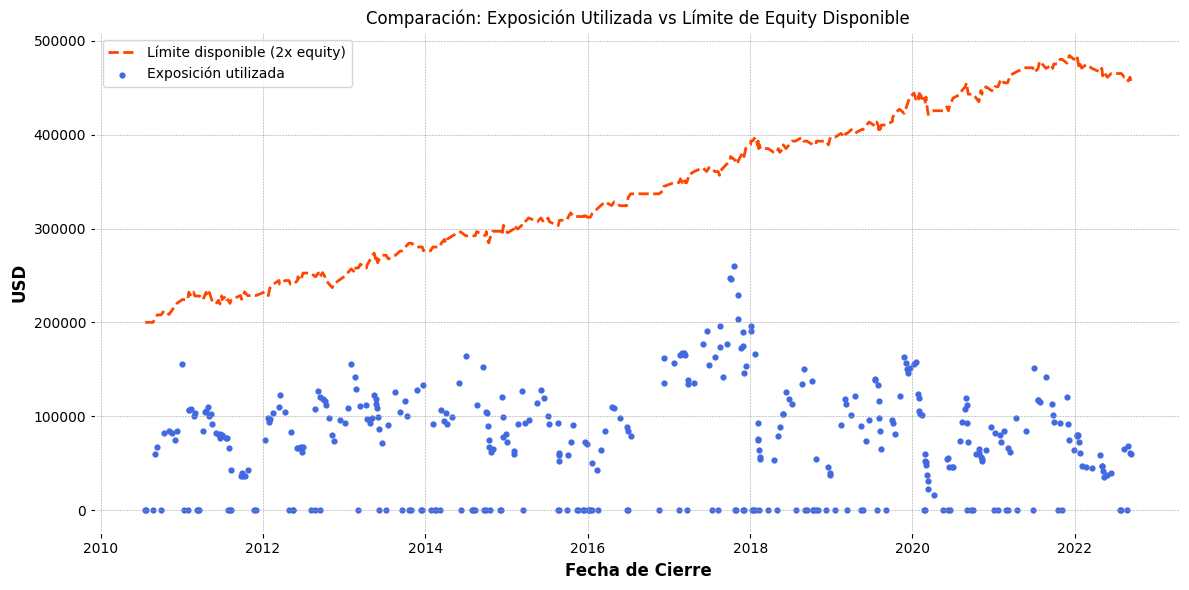

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(dfg['Fecha_Cierre'], dfg['Limite_Equity'], label='Límite disponible (2x equity)', color='orangered', linestyle='--')
plt.scatter(dfg['Fecha_Cierre'], dfg['Exposicion'], label='Exposición utilizada', color='royalblue', s=12)

plt.xlabel('Fecha de Cierre')
plt.ylabel('USD')
plt.title('Comparación: Exposición Utilizada vs Límite de Equity Disponible')
plt.legend()
plt.tight_layout()
plt.show()

## Probabilistic Sharpe Ratio

In [ ]:
from scipy.stats import norm

def probabilistic_sharpe_ratio(SR_observed, SR_benchmark, returns, periods_per_year=None):
    """
    Calcula el PSR: probabilidad de que el Sharpe real supere a SR_benchmark
    Basado en Bailey & López de Prado (2012), Eq. 18 y 19.

    - SR_observed: Sharpe Ratio de la estrategia evaluada
    - SR_benchmark: Sharpe Ratio de referencia (ej: Buy & Hold, o 0)
    - returns: Serie de retornos periódicos (pueden ser diarios, o de evento)
    - periods_per_year: eventos por año (para anualizar, opcional)
    """
    n = len(returns)
    mean = np.mean(returns)
    std  = np.std(returns, ddof=0)
    skew = ((returns - mean)**3).mean() / (std**3) if std > 0 else 0
    kurt = ((returns - mean)**4).mean() / (std**4) if std > 0 else 3

    # Si periods_per_year no está especificado, lo estimo por la frecuencia
    if periods_per_year is None:
        periods_per_year = 252 if n > 250 else 12 if n < 50 else n/(returns.index[-1] - returns.index[0]).days * 365.25

    # Bailey-López de Prado Eq.19
    numerator = SR_observed - SR_benchmark
    denominator = np.sqrt(
        (1 - skew * SR_observed + 0.25 * (kurt - 1) * SR_observed**2) / (n - 1)
    )
    psr = norm.cdf(numerator / denominator)
    return psr

# --- CALCULO PSR GLOBAL DE TU ESTRATEGIA VS BUY & HOLD ---

# Tu serie de retornos globales de la estrategia (ya la tienes como rets_g)
rets_global = rets_g

# Tu Sharpe global
sharpe_strat = sharpe_g

# Sharpe global del Buy & Hold (ya lo tienes en sharpe_g de ese bloque, o asignalólo explícitamente)
sharpe_bh = sharpe_g  # <-- Ajusta si lo tienes con otro nombre

# Calcular PSR (probabilidad de que el Sharpe real de tu estrategia supere el BH)
psr = probabilistic_sharpe_ratio(
    SR_observed = sharpe_strat,
    SR_benchmark = sharpe_bh,
    returns = rets_global
)

print(f"Probabilistic Sharpe Ratio (PSR) vs BH: {psr:.4f}")

# Opcional: PSR vs. cero
psr_vs_0 = probabilistic_sharpe_ratio(
    SR_observed = sharpe_strat,
    SR_benchmark = 0.0,
    returns = rets_global
)
print(f"Probabilistic Sharpe Ratio (PSR) vs 0: {psr_vs_0:.4f}")

Probabilistic Sharpe Ratio (PSR) vs BH: 0.5000
Probabilistic Sharpe Ratio (PSR) vs 0: 1.0000


In [ ]:
# Generar la curva de equity diaria interpolada

# --- Supón que dfg tiene las columnas: 'Fecha_Cierre', 'Equity_global'
dfg = dfg.sort_values("Fecha_Cierre").copy()
dfg['Fecha_Cierre'] = pd.to_datetime(dfg['Fecha_Cierre'])
dfg = dfg.set_index('Fecha_Cierre')

# --- Fechas diarias del benchmark (por ejemplo, de precios_glob)
fechas_diarias = pd.date_range(start=dfg.index.min(), end=dfg.index.max(), freq='B')  # 'B' = business day

# --- Interpolamos el equity para cada día hábil
equity_diaria = dfg['Equity_global'].reindex(fechas_diarias, method='ffill')

# --- Si hay días previos sin trade, puede que queden NaN al principio: rellena con el capital inicial
equity_diaria = equity_diaria.fillna(capital_inicial)

In [ ]:
# Calcula los retornos diarios y las métricas

rets_diarios = equity_diaria.pct_change().dropna()
years_glob = (fechas_diarias[-1] - fechas_diarias[0]).days / 365.25
events_per_year_glob = len(rets_diarios) / years_glob

mean_ret_glob = rets_diarios.mean()
std_ret_glob = rets_diarios.std(ddof=0)
sharpe_glob = (mean_ret_glob / std_ret_glob) * np.sqrt(events_per_year_glob) if std_ret_glob > 0 else np.nan

neg_rets_glob = rets_diarios[rets_diarios < 0]
sortino_glob = (mean_ret_glob / neg_rets_glob.std(ddof=0)) * np.sqrt(events_per_year_glob) if len(neg_rets_glob) > 0 else np.nan

running_max_glob = equity_diaria.cummax()
drawdowns_glob = equity_diaria / running_max_glob - 1
mdd_glob = drawdowns_glob.min()
cagr_glob = (equity_diaria.iloc[-1] / equity_diaria.iloc[0]) ** (1 / years_glob) - 1
calmar_glob = cagr_glob / abs(mdd_glob) if mdd_glob < 0 else np.nan

print(f"\n=== Métricas Globales (curva diaria interpolada) ===")
print(f"Total Return       : {equity_diaria.iloc[-1] / equity_diaria.iloc[0] - 1:.2%}")
print(f"CAGR               : {cagr_glob:.2%}")
print(f"Sharpe             : {sharpe_glob:.2f}")
print(f"Sortino            : {sortino_glob:.2f}")
print(f"MDD                : {mdd_glob:.2%}")
print(f"Calmar             : {calmar_glob:.2f}")


=== Métricas Globales (curva diaria interpolada) ===
Total Return       : 128.63%
CAGR               : 7.05%
Sharpe             : 1.09
Sortino            : 1.24
MDD                : -6.35%
Calmar             : 1.11


In [ ]:
# Calcular el PSR ahora sí, 100% comparable

def probabilistic_sharpe_ratio(sharpe_model, sharpe_benchmark, n):
    # n: número de retornos (eventos diarios)
    # Fórmula de Bailey & López de Prado
    psr = norm.cdf((sharpe_model - sharpe_benchmark) * np.sqrt(n - 1) / np.sqrt(1 - sharpe_model**2 / 4))
    return psr

n_diarios = len(rets_diarios)
psr_bh = probabilistic_sharpe_ratio(sharpe_model=sharpe_glob, sharpe_benchmark=sharpe_bh, n=n_diarios)
psr_0  = probabilistic_sharpe_ratio(sharpe_model=sharpe_glob, sharpe_benchmark=0.0, n=n_diarios)
print(f"PSR vs BH diario: {psr_bh:.4f}")
print(f"PSR vs 0:         {psr_0:.4f}")

PSR vs BH diario: 1.0000
PSR vs 0:         1.0000


## Nuevo Dimensionamiento de Posición

In [ ]:
# --- NUEVA FUNCIÓN DE BACKTEST CON RATCHET ---
def ejecutar_backtest_ratchet(df, signal_col='Signal', capital_inicial=100_000.0, riesgo_pct=0.02,
                             spread=0.01, comision_por_accion=0.001):
    df = df.copy().reset_index(drop=True)
    df['EntryPrice'] = df['Precio_Cierre']
    df['ExitPrice']  = df['Precio_Cierre'].shift(-1)

    high_water_equity = capital_inicial
    equity = capital_inicial
    records = []

    for _, row in df.iterrows():
        if row[signal_col] == 1 and not pd.isna(row['ExitPrice']):
            # Riesgo absoluto basado en High-Water Mark
            riesgo_abs = high_water_equity * riesgo_pct
            # Riesgo por acción (diferencia entre entrada y SL)
            riesgo_por_accion = abs(row['EntryPrice'] - row['SL'])
            shares = riesgo_abs / riesgo_por_accion if riesgo_por_accion > 0 else 0.0
            # Cálculo de PnL neto
            gross_pnl = shares * (row['ExitPrice'] - row['EntryPrice'])
            cost = shares * (spread + comision_por_accion)
            net_pnl = gross_pnl - cost
        else:
            shares = 0.0
            net_pnl = 0.0

        equity += net_pnl
        # Actualizar High-Water Mark
        if equity > high_water_equity:
            high_water_equity = equity

        records.append({
            'Fecha_Cierre':    row['Fecha_Cierre'],
            'EntryPrice':      row['EntryPrice'],
            'Shares':          shares,
            'NetPnL':          net_pnl,
            'Equity':          equity
        })

    return pd.DataFrame(records)

# --- PARÁMETROS Y PREPARACIÓN ---
xgb_params = {
    'learning_rate':     0.1,
    'n_estimators':      150,
    'max_depth':         4,
    'min_child_weight':  2,
    'subsample':         0.8,
    'colsample_bytree':  0.8,
    'gamma':             0.1,
    'reg_alpha':         0.1,
    'reg_lambda':        1.5,
    'use_label_encoder': False,
    'eval_metric':       'logloss',
    'random_state':      42
}
threshold           = 0.45
capital_inicial     = 100_000.0
riesgo_pct          = 0.02
spread              = 0.01
comision_por_accion = 0.001

static_feats = ['VIX_Open','Retornos_10']
df_train["Señal"] = np.nan
df_train["Probabilidad_Señal"] = np.nan

metrics      = []
df_global_bt = pd.DataFrame()

# --- BUCLE DE TRAIN-VALIDACIÓN Y BACKTEST ---
for i, (idx_tr, idx_va) in enumerate(folds, start=1):
    cond_col = f'HMM_cond_fold_{i}'
    feats = static_feats + [cond_col]

    # Preparación de datos de entrenamiento
    df_tr = df_train.loc[idx_tr, feats + ['Objetivo']].copy()
    df_tr = pd.get_dummies(df_tr, columns=[cond_col], prefix=f'HMM_c{i}')
    X_tr = df_tr.drop(columns='Objetivo')
    y_tr = df_tr['Objetivo']

    model = XGBClassifier(**xgb_params)
    model.fit(X_tr, y_tr)

    # Preparación de datos de validación
    df_val = df_train.loc[idx_va, feats + ['Objetivo','Precio_Cierre','SL','Fecha_Cierre']].copy()
    df_val = pd.get_dummies(df_val, columns=[cond_col], prefix=f'HMM_c{i}')
    for col in X_tr.columns:
        if col not in df_val.columns:
            df_val[col] = 0
    X_va = df_val[X_tr.columns]

    # Predicción
    y_prob = model.predict_proba(X_va)[:,1]
    y_pred = (y_prob >= threshold).astype(int)
    df_val['Signal']             = y_pred
    df_train.loc[idx_va, 'Señal']             = y_pred
    df_train.loc[idx_va, 'Probabilidad_Señal'] = y_prob

    # Backtest con ratchet
    df_bt = ejecutar_backtest_ratchet(
        df_val,
        signal_col='Signal',
        capital_inicial=capital_inicial,
        riesgo_pct=riesgo_pct,
        spread=spread,
        comision_por_accion=comision_por_accion
    )

    # Cálculo de métricas por fold (idéntico al anterior)
    equity = df_bt['Equity']
    fechas = pd.to_datetime(df_bt['Fecha_Cierre'])
    anios = (fechas.iloc[-1] - fechas.iloc[0]).days / 365.25 or (1/365.25)

    total_ret = equity.iloc[-1]/equity.iloc[0] - 1
    cagr = (equity.iloc[-1] / equity.iloc[0])**(1/anios) - 1
    running_max = equity.cummax()
    drawdowns = equity / running_max - 1
    mdd = drawdowns.min()
    calmar = cagr / abs(mdd) if mdd < 0 else np.nan
    tuw = (equity < running_max).mean()

    df_trades = df_bt[df_bt['Shares'] > 0]
    num_trades = len(df_trades)
    if num_trades > 0:
        hit_rate = (df_trades['NetPnL'] > 0).mean()
        wins = df_trades.loc[df_trades['NetPnL'] > 0, 'NetPnL'].sum()
        loses = -df_trades.loc[df_trades['NetPnL'] < 0, 'NetPnL'].sum()
        profit_factor = wins / loses if loses > 0 else np.nan
    else:
        hit_rate = np.nan
        profit_factor = np.nan

    rets = df_bt['NetPnL'] / equity.iloc[0]
    mean_ret = rets.mean()
    std_ret = rets.std(ddof=0)
    events_per_year = len(rets) / anios
    sharpe = (mean_ret / std_ret) * np.sqrt(events_per_year) if std_ret > 0 else np.nan
    neg_rets = rets[rets < 0]
    sortino = (mean_ret / neg_rets.std(ddof=0)) * np.sqrt(events_per_year) if len(neg_rets) > 0 else np.nan

    metrics.append({
        'fold':       i,
        'TotalRet':   total_ret,
        'CAGR':       cagr,
        'Sharpe':     sharpe,
        'Sortino':    sortino,
        'MDD':        mdd,
        'Calmar':     calmar,
        'NumTrades':  num_trades,
        'HitRate':    hit_rate,
        'ProfitFactor': profit_factor,
        'TUW':        tuw
    })

    df_global_bt = pd.concat([df_global_bt, df_bt], axis=0)

df_metrics = pd.DataFrame(metrics).set_index('fold')
print("=== Métricas por Fold ===")
print(df_metrics[['TotalRet','CAGR','Sharpe','Sortino','MDD','Calmar','NumTrades','HitRate','ProfitFactor','TUW']])

# Guardar métricas por fold a Excel
df_metrics.to_excel('metricas_xgboost_por_fold.xlsx')

# --- MÉTRICAS GLOBALES (estrategia) ---
dfg = df_global_bt.sort_values('Fecha_Cierre').copy()
dfg['Equity_global'] = capital_inicial + dfg['NetPnL'].cumsum()


# --- Cálculo de exposición promedio ---
# Exposición monetaria: Shares * EntryPrice en cada evento, 0 si no hay operación
dfg['Exposicion'] = dfg['Shares'] * dfg['EntryPrice']
# Exposición promedio sobre todos los eventos (incluidos los de exposición 0)
exposicion_prom_g = dfg['Exposicion'].mean()
exposicion_prom_pct = exposicion_prom_g / capital_inicial  # % sobre el capital inicial

equity_g    = dfg['Equity_global']
start_g     = pd.to_datetime(dfg['Fecha_Cierre'].iloc[0])
end_g       = pd.to_datetime(dfg['Fecha_Cierre'].iloc[-1])
years_g     = (end_g - start_g).days / 365.25 or (1/365.25)
total_ret_g = equity_g.iloc[-1] / equity_g.iloc[0] - 1
rets_g            = equity_g.pct_change().dropna()
events_per_year_g = len(rets_g) / years_g
mean_ret_g        = rets_g.mean()
std_ret_g         = rets_g.std(ddof=0)
sharpe_g          = (mean_ret_g / std_ret_g) * np.sqrt(events_per_year_g) if std_ret_g>0 else np.nan
neg_rets_g        = rets_g[rets_g < 0]
sortino_g         = (mean_ret_g / neg_rets_g.std(ddof=0)) * np.sqrt(events_per_year_g) if len(neg_rets_g)>0 else np.nan
cagr_g        = (equity_g.iloc[-1] / equity_g.iloc[0])**(1/years_g) - 1
running_max_g = equity_g.cummax()
drawdowns_g   = equity_g / running_max_g - 1
mdd_g         = drawdowns_g.min()
calmar_g      = cagr_g / abs(mdd_g) if mdd_g<0 else np.nan
df_trades_g      = dfg[dfg['Shares'] > 0]
hit_rate_g       = (df_trades_g['NetPnL'] > 0).mean()
wins_g           = df_trades_g['NetPnL'][df_trades_g['NetPnL']>0].sum()
loses_g          = -df_trades_g['NetPnL'][df_trades_g['NetPnL']<0].sum()
profit_factor_g  = wins_g / loses_g if loses_g>0 else np.nan
tuw_g            = (equity_g < running_max_g).mean()

# --- Eficiencia del capital ---
eficiencia_capital = cagr_g / exposicion_prom_pct if exposicion_prom_pct > 0 else np.nan

print("\n=== Métricas Globales ===")
print(f"Total Return global      : {total_ret_g:.2%}")
print(f"CAGR global              : {cagr_g:.2%}")
print(f"Sharpe global            : {sharpe_g:.2f}")
print(f"Sortino global           : {sortino_g:.2f}")
print(f"MDD global               : {mdd_g:.2f}")
print(f"Calmar global            : {calmar_g:.2f}")
print(f"Hit-Rate global          : {hit_rate_g:.2%}")
print(f"Profit Factor global     : {profit_factor_g:.2f}")
print(f"Time Under Water global  : {tuw_g:.2%}")
print(f"\n--- Exposición Promedio del Capital ---")
print(f"Exposición promedio      : ${exposicion_prom_g:,.2f} ({exposicion_prom_pct:.2%} del capital inicial)")
print(f"Eficiencia del capital   : {eficiencia_capital:.2%}")

# Guardar resultados globales en un nuevo DataFrame y a Excel
resultados_globales = pd.DataFrame({
    'TotalRet_global': [total_ret_g],
    'CAGR_global': [cagr_g],
    'Sharpe_global': [sharpe_g],
    'Sortino_global': [sortino_g],
    'MDD_global': [mdd_g],
    'Calmar_global': [calmar_g],
    'HitRate_global': [hit_rate_g],
    'ProfitFactor_global': [profit_factor_g],
    'TUW_global': [tuw_g],
    'Exposicion_promedio': [exposicion_prom_g],
    'Exposicion_promedio_pct': [exposicion_prom_pct],
    'Eficiencia_capital': [eficiencia_capital]
})

resultados_globales.to_excel('metricas_xgboost_global.xlsx', index=False)

=== Métricas por Fold ===
      TotalRet    CAGR  Sharpe  Sortino     MDD  Calmar  NumTrades  HitRate  \
fold                                                                          
1       0.1021  0.0980  0.8127  19.4892 -0.0632  1.5493         29   0.5862   
2       0.1055  0.0807  0.7699  15.1232 -0.0804  1.0043         29   0.5862   
3       0.2143  0.1648  1.7856   7.5051 -0.0514  3.2037         27   0.7037   
4       0.0940  0.0741  0.8696  10.1590 -0.0604  1.2279         29   0.5862   
5       0.2059  0.1244  1.7747  18.3931 -0.0401  3.1020         24   0.7083   
6       0.2714  0.2821  2.5086  40.2939 -0.0404  6.9892         28   0.7143   
7       0.0683  0.0544  0.1548   0.3840 -0.0615  0.8839         26   0.5385   
8       0.0730  0.0866  0.6715   1.8719 -0.1246  0.6951         33   0.6061   
9       0.2301  0.2076  1.9689  41.7471 -0.1001  2.0728         28   0.6786   
10     -0.0779 -0.0600 -0.3895  -1.6560 -0.1358 -0.4416         33   0.4848   

      ProfitFactor    TUW

# 5. Importancia de las características

**Economic Permutational Importance**

In [ ]:
# --- PERMUTATIONAL IMPORTANCE ECONÓMICA ---
perm_importances = {}
metrics_list = ['Sharpe','Sortino','CAGR','MDD','HitRate']

for i, (idx_tr, idx_va) in enumerate(folds, start=1):
    cond_col  = f'HMM_cond_fold_{i}'
    features  = static_feats + [cond_col]
    X_tr = df_train.loc[idx_tr, features]
    y_tr = df_train.loc[idx_tr, 'Objetivo']
    model = XGBClassifier(**xgb_params)
    model.fit(X_tr, y_tr)
    df_val = df_train.loc[idx_va, features + ['Precio_Cierre','SL','Fecha_Cierre']].copy()
    X_va = df_val[features]
    y_prob = model.predict_proba(X_va)[:,1]
    y_pred = (y_prob >= threshold).astype(int)
    df_val['Signal'] = y_pred
    df_bt_base = ejecutar_backtest(df_val, signal_col='Signal', capital_inicial=capital_inicial)
    base_metrics = extraer_metricas(df_bt_base)
    for feat in features:
        perm_importances.setdefault(feat, {m: [] for m in metrics_list})
    for feat in features:
        X_perm = X_va.copy()
        X_perm[feat] = np.random.permutation(X_perm[feat].values)
        y_prob_p = model.predict_proba(X_perm)[:,1]
        y_pred_p = (y_prob_p >= threshold).astype(int)
        df_val['Signal'] = y_pred_p
        df_bt_perm = ejecutar_backtest(df_val, signal_col='Signal', capital_inicial=capital_inicial)
        perm_metrics = extraer_metricas(df_bt_perm)
        for j, m in enumerate(metrics_list):
            perm_importances[feat][m].append(base_metrics[j] - perm_metrics[j])

features_list = list(perm_importances.keys())
df_imp = pd.DataFrame({
    m: [np.mean(perm_importances[f][m]) for f in features_list]
    for m in metrics_list
}, index=features_list)

print("Importancia permutacional (media caída en cada métrica):")
print(df_imp)

# --- Guardar resultados en Excel ---
df_imp.to_excel("perm_importances.xlsx", index=True)
print("Archivo 'perm_importances.xlsx' guardado correctamente.")

Importancia permutacional (media caída en cada métrica):
                  Sharpe   Sortino    CAGR     MDD  HitRate
VIX_Open          0.1370 -333.7330  0.0158  0.0103   0.0205
Retornos_10       0.2076  500.8392  0.0228 -0.0058   0.0359
HMM_cond_fold_1  -0.2194  -24.3735 -0.0042 -0.0195  -0.0256
HMM_cond_fold_2  -0.1530  -30.3112 -0.0151 -0.0011  -0.0256
HMM_cond_fold_3   0.0000    0.0000  0.0000  0.0000   0.0000
HMM_cond_fold_4   0.1722    0.8692  0.0158  0.0105   0.0000
HMM_cond_fold_5   0.1494    2.0076  0.0120  0.0000   0.0256
HMM_cond_fold_6   0.0000    0.0000  0.0000  0.0000   0.0000
HMM_cond_fold_7  -0.1600   -0.4424 -0.0175 -0.0189   0.0000
HMM_cond_fold_8   0.0000    0.0000  0.0000  0.0000   0.0000
HMM_cond_fold_9   0.0000    0.0000  0.0000  0.0000   0.0000
HMM_cond_fold_10  0.0000    0.0000  0.0000  0.0000   0.0000
Archivo 'perm_importances.xlsx' guardado correctamente.


In [ ]:
import base64
from io import BytesIO
from IPython.display import HTML

# 1) Volcar df_imp a un buffer Excel en memoria
buffer = BytesIO()
df_imp.to_excel(buffer, sheet_name='Importance', index=True)
buffer.seek(0)

# 2) Codificar en base64
b64 = base64.b64encode(buffer.read()).decode()

# 3) Mostrar enlace HTML para descarga
display(HTML(
    f'<a download="perm_importance.xlsx" '
    f'href="data:application/vnd.openxmlformats-officedocument.spreadsheetml.sheet;base64,{b64}">'
    f'⬇️ Descargar perm_importance.xlsx</a>'
))

**Feature Importance**

Importancia promedio XGBoost:
       Feature  Importance
0     VIX_Open      0.3017
1  Retornos_10      0.2896
2    HMM_c10_0      0.2408
3    HMM_c10_1      0.1679


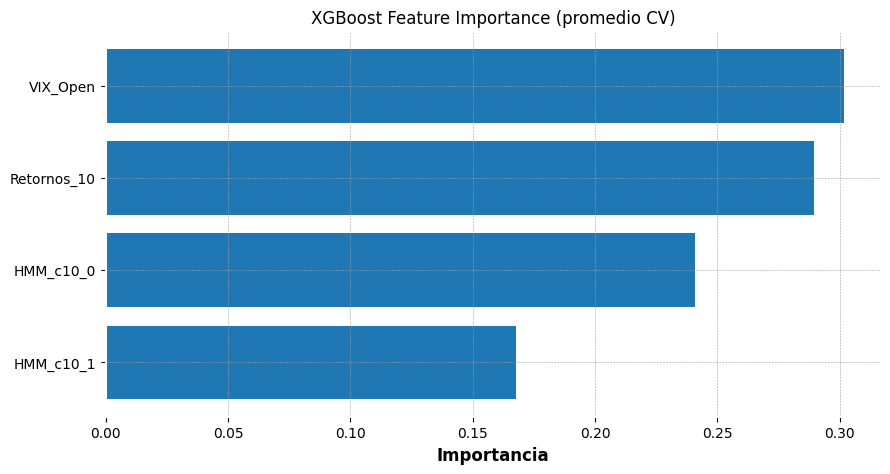

In [ ]:
importances_fold = []

for i, (idx_tr, idx_va) in enumerate(folds, start=1):
    cond_col = f'HMM_cond_fold_{i}'
    features = static_feats + [cond_col]
    df_tr = df_train.loc[idx_tr, features + ['Objetivo']].copy()
    df_tr = pd.get_dummies(df_tr, columns=[cond_col], prefix=f'HMM_c{i}')
    X_tr = df_tr.drop(columns='Objetivo')
    y_tr = df_tr['Objetivo']

    model = XGBClassifier(**xgb_params)
    model.fit(X_tr, y_tr)

    importances = model.feature_importances_
    importances_fold.append(importances)

# Promedio por feature (usando las columnas del último fold)
feature_names = X_tr.columns
importances_fold = np.array(importances_fold)
importances_mean = np.mean(importances_fold, axis=0)

# Mostrar importancia promedio
df_feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances_mean
}).sort_values("Importance", ascending=False)
print("Importancia promedio XGBoost:")
print(df_feat_imp)

# Opcional: gráfico
plt.figure(figsize=(10,5))
plt.barh(df_feat_imp["Feature"], df_feat_imp["Importance"])
plt.title("XGBoost Feature Importance (promedio CV)")
plt.xlabel("Importancia")
plt.gca().invert_yaxis()
plt.show()

**SHAP Values**

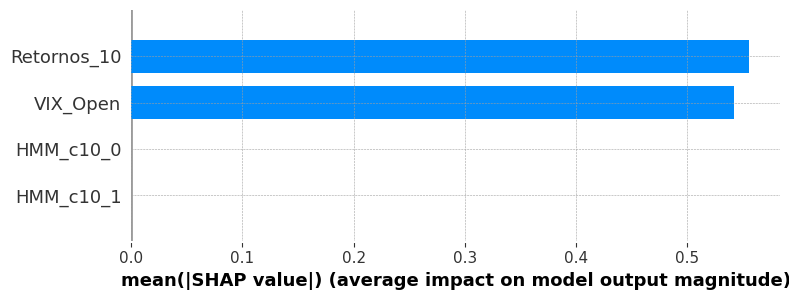

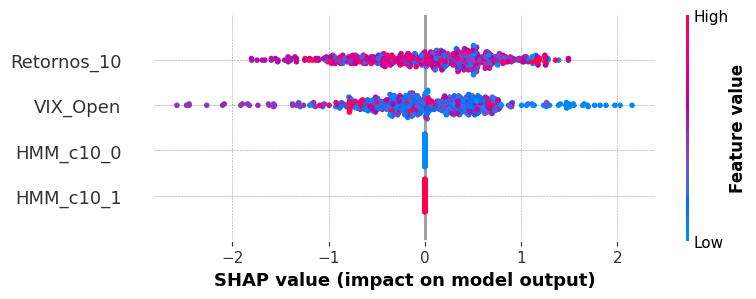

In [ ]:
import shap

# Último fold
idx_tr, idx_va = folds[-1]
cond_col = f'HMM_cond_fold_{len(folds)}'
features = static_feats + [cond_col]
df_tr = df_train.loc[idx_tr, features + ['Objetivo']].copy()
df_tr = pd.get_dummies(df_tr, columns=[cond_col], prefix=f'HMM_c{len(folds)}')
X_tr = df_tr.drop(columns='Objetivo')
y_tr = df_tr['Objetivo']

model = XGBClassifier(**xgb_params)
model.fit(X_tr, y_tr)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_tr)

# SHAP summary plot
shap.summary_plot(shap_values, X_tr, plot_type="bar", show=True) # Barras
shap.summary_plot(shap_values, X_tr, show=True)                  # Beeswarm (más detallado)

# 6. Metamodelo

## Ingeniería de características

In [ ]:
tickers = ['EEM', 'TLT', 'GLD', 'DBC', 'USO', 'VNQ', 'UUP']

# --- Descargar precios ---
data_dict = {}
for ticker in tickers:
    print(f"Descargando {ticker}...")
    data = yf.download(ticker, start=df_train['Fecha_Cierre'].min(), end=df_train['Fecha_Cierre'].max(), progress=False)
    # Nos quedamos solo con Close
    data = data[['Close']].rename(columns={'Close': f'Close_{ticker}'})
    data.index = pd.to_datetime(data.index)
    data_dict[ticker] = data

df_prices = pd.concat(data_dict.values(), axis=1)
df_prices = df_prices.reindex(pd.to_datetime(df_train['Fecha_Cierre'])).ffill()

# --- Agregar precios y retornos a df_train ---
for ticker in tickers:
    # Agregar precios
    col_price = f'Close_{ticker}'
    df_train[col_price] = df_prices[col_price].values
    # Calcular retorno porcentual de 10 eventos previos
    df_train[f'Retornos_10_{ticker}'] = df_train[col_price].pct_change(periods=10)
    # Alternativamente, retorno logarítmico (descomentar si prefieres log)
    # df_train[f'Retornos_10_{ticker}'] = (np.log(df_train[col_price]) - np.log(df_train[col_price].shift(10)))

print("Muestra de df_train con precios y retornos de otros activos:")
display(df_train[[f'Close_{t}' for t in tickers] + [f'Retornos_10_{t}' for t in tickers]].tail())

Descargando EEM...
Descargando TLT...
Descargando GLD...
Descargando DBC...
Descargando USO...
Descargando VNQ...
Descargando UUP...
Muestra de df_train con precios y retornos de otros activos:


,Close_EEM,Close_TLT,Close_GLD,Close_DBC,Close_USO,Close_VNQ,Close_UUP,Retornos_10_EEM,Retornos_10_TLT,Retornos_10_GLD,Retornos_10_DBC,Retornos_10_USO,Retornos_10_VNQ,Retornos_10_UUP
895,36.6949,100.7856,161.6400,23.5559,74.6800,85.7543,26.0063,-0.0519,-0.0636,-0.0870,-0.0282,0.0004,-0.1051,0.0732
896,36.8897,100.8035,161.8600,24.3024,78.6900,83.4728,25.9796,-0.0525,-0.0330,-0.0678,-0.0333,0.0040,-0.0598,0.0516
897,35.5351,96.3638,158.3300,22.6565,71.4200,81.6670,26.3451,-0.1036,-0.0868,-0.0994,-0.1137,-0.1097,-0.1018,0.0773
898,36.1846,97.0989,159.8200,22.8364,71.1000,84.3977,26.0242,-0.0391,-0.0398,-0.0889,-0.1028,-0.1343,-0.0348,0.0534
899,36.1846,97.0989,159.8200,22.8364,71.1000,84.3977,26.0242,-0.0017,-0.0728,-0.0608,-0.0817,-0.1026,0.0226,0.0406


In [ ]:
for ticker in tickers:
    # Primer dato disponible en precios
    col_price = f'Close_{ticker}'
    first_price_idx = df_train[col_price].first_valid_index()
    first_price_date = df_train.loc[first_price_idx, 'Fecha_Cierre']
    print(f"Primer Close_{ticker}: idx={first_price_idx}, Fecha={first_price_date}")

    # Primer dato disponible en retornos
    col_ret = f'Retornos_10_{ticker}'
    first_ret_idx = df_train[col_ret].first_valid_index()
    first_ret_date = df_train.loc[first_ret_idx, 'Fecha_Cierre']
    print(f"Primer Retornos_10_{ticker}: idx={first_ret_idx}, Fecha={first_ret_date}\n")

Primer Close_EEM: idx=307, Fecha=2003-04-22 00:00:00
Primer Retornos_10_EEM: idx=317, Fecha=2003-10-03 00:00:00

Primer Close_TLT: idx=291, Fecha=2002-08-09 00:00:00
Primer Retornos_10_TLT: idx=301, Fecha=2003-02-06 00:00:00

Primer Close_GLD: idx=342, Fecha=2004-12-02 00:00:00
Primer Retornos_10_GLD: idx=352, Fecha=2005-04-07 00:00:00

Primer Close_DBC: idx=372, Fecha=2006-02-16 00:00:00
Primer Retornos_10_DBC: idx=382, Fecha=2006-09-26 00:00:00

Primer Close_USO: idx=374, Fecha=2006-04-11 00:00:00
Primer Retornos_10_USO: idx=384, Fecha=2006-10-16 00:00:00

Primer Close_VNQ: idx=336, Fecha=2004-10-04 00:00:00
Primer Retornos_10_VNQ: idx=346, Fecha=2005-02-02 00:00:00

Primer Close_UUP: idx=397, Fecha=2007-03-05 00:00:00
Primer Retornos_10_UUP: idx=407, Fecha=2007-06-07 00:00:00



In [ ]:
# Inicializa Objetivo_Señal con NaN
df_train["Objetivo_Señal"] = np.nan

# Vectorizado: donde Señal == 1, evaluamos el objetivo
mask_signal = df_train["Señal"] == 1
precio_cierre = df_train["Precio_Cierre"]
precio_cierre_sig = precio_cierre.shift(-1)

# Etiqueta como 1 si el precio siguiente es mayor, sino 0, solo para señales==1
df_train.loc[mask_signal, "Objetivo_Señal"] = (precio_cierre_sig > precio_cierre)[mask_signal].astype(int)

# Opcional: para ver el resultado
print(df_train[["Señal", "Precio_Cierre", "Objetivo_Señal"]].tail(10))

     Señal  Precio_Cierre  Objetivo_Señal
890 1.0000       391.7402          0.0000
891 1.0000       362.4909          1.0000
892 0.0000       381.0168             NaN
893 0.0000       395.2033             NaN
894 1.0000       409.1445          0.0000
895 0.0000       396.4895             NaN
896 1.0000       384.6252          0.0000
897 1.0000       373.2996          1.0000
898 1.0000       385.9951          0.0000
899 0.0000       373.1244             NaN


In [ ]:
# Conaar los valores de la columna "Objetico Señal"
print(df_train["Objetivo_Señal"].value_counts())
# Calcular proporción sobre los valores validos de "Objetivo_Señal"
print(df_train["Objetivo_Señal"].value_counts(normalize=True))

Objetivo_Señal
1.0000    178
0.0000    113
Name: count, dtype: int64
Objetivo_Señal
1.0000   0.6117
0.0000   0.3883
Name: proportion, dtype: float64


## Entrenamiento y Backtest

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, classification_report

# --- 1. Features y dataset de señales ---
features_meta = [
    "Retornos_10", "Retornos_10_EEM", "Retornos_10_TLT",
    "Retornos_10_VNQ", "Retornos_10_GLD"
]

df_signals = df_train[df_train['Señal'] == 1].copy()
df_signals = df_signals[df_signals['Objetivo_Señal'].notna()].reset_index(drop=True)

print(f"Total de señales detectadas: {len(df_signals)}")

# --- 2. Rolling meta-modelo ---
N_TRAIN = 150
preds = []
probs = []
true = []
idxs = []

meta_model = LGBMClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    random_state=42,
    verbosity=-1   # <--- suprime warnings LightGBM
)

for i in range(N_TRAIN, len(df_signals)):
    X_train = df_signals.loc[:i-1, features_meta]
    y_train = df_signals.loc[:i-1, "Objetivo_Señal"]
    X_test  = df_signals.loc[i:i, features_meta]
    y_test  = df_signals.loc[i:i, "Objetivo_Señal"]

    meta_model.fit(X_train, y_train)
    prob = meta_model.predict_proba(X_test)[:,1][0]
    pred = int(prob >= 0.39)

    probs.append(prob)
    preds.append(pred)
    true.append(int(y_test.values[0]))
    idxs.append(df_signals.index[i])

# --- 3. Métricas de clasificación ---
print("=== Métricas Meta-modelo ===")
print(classification_report(true, preds, digits=3))
print(f"Accuracy:   {accuracy_score(true, preds):.3f}")
print(f"Recall:     {recall_score(true, preds):.3f}")
print(f"Precision:  {precision_score(true, preds):.3f}")
print(f"F1-score:   {f1_score(true, preds):.3f}")
print(f"AUC:        {roc_auc_score(true, probs):.3f}")

# --- 4. Filtro meta-modelo ---
df_signals['Meta_Filtro'] = 1   # Las primeras N_TRAIN entran siempre
df_signals.loc[N_TRAIN:, 'Meta_Filtro'] = preds

# --- 5. Construcción de señal meta-modelo en df_train ---
df_train['Meta_Señal'] = 0
signal_idx = df_signals.index.values
for i, idx in enumerate(signal_idx):
    if i < N_TRAIN:
        df_train.loc[idx, 'Meta_Señal'] = 1
    else:
        df_train.loc[idx, 'Meta_Señal'] = preds[i-N_TRAIN]

# --- 6. DataFrame de señales meta-filtradas ---
df_meta_signals = df_train[df_train['Meta_Señal']==1].copy()

print(f"Total de señales ejecutadas tras filtro meta-modelo: {len(df_meta_signals)}")

# --- 7. Backtest sobre señales filtradas ---
df_bt_meta = df_meta_signals.copy()
df_bt_meta['EntryPrice'] = df_bt_meta['Precio_Cierre']
df_bt_meta['ExitPrice']  = df_bt_meta['Precio_Cierre'].shift(-1)
df_bt_meta['Distance']   = np.abs(df_bt_meta['EntryPrice'] - df_bt_meta['SL'])
df_bt_meta['Shares']     = np.where(df_bt_meta['Distance'] > 0,
                                    capital_inicial * riesgo_pct / df_bt_meta['Distance'], 0.0)
df_bt_meta = df_bt_meta.iloc[:-1].copy()  # última fila no tiene salida
df_bt_meta['GrossPnL'] = df_bt_meta['Shares'] * (df_bt_meta['ExitPrice'] - df_bt_meta['EntryPrice'])
df_bt_meta['Cost']     = df_bt_meta['Shares'] * (spread + comision_por_accion)
df_bt_meta['NetPnL']   = df_bt_meta['GrossPnL'] - df_bt_meta['Cost']
df_bt_meta['Equity']   = capital_inicial + df_bt_meta['NetPnL'].cumsum()

# --- 8. Métricas económicas finales ---
equity = df_bt_meta['Equity']
fechas = pd.to_datetime(df_bt_meta['Fecha_Cierre'])
anios = (fechas.iloc[-1] - fechas.iloc[0]).days / 365.25
if anios <= 0:
    anios = 1/365.25

total_ret = equity.iloc[-1]/equity.iloc[0] - 1
cagr = (equity.iloc[-1] / equity.iloc[0])**(1/anios) - 1
running_max = equity.cummax()
drawdowns = equity / running_max - 1
mdd = drawdowns.min()
calmar = cagr / abs(mdd) if mdd < 0 else np.nan
tuw = (equity < running_max).mean()

df_trades = df_bt_meta[df_bt_meta['Shares'] > 0]
num_trades = len(df_trades)
if num_trades > 0:
    hit_rate = (df_trades['NetPnL'] > 0).mean()
    wins = df_trades.loc[df_trades['NetPnL'] > 0, 'NetPnL'].sum()
    loses = -df_trades.loc[df_trades['NetPnL'] < 0, 'NetPnL'].sum()
    profit_factor = wins / loses if loses > 0 else np.nan
else:
    hit_rate = np.nan
    profit_factor = np.nan

rets = df_bt_meta['NetPnL'] / equity.iloc[0]
mean_ret = rets.mean()
std_ret = rets.std(ddof=0)
events_per_year = len(rets) / anios
sharpe = (mean_ret / std_ret) * np.sqrt(events_per_year) if std_ret > 0 else np.nan
neg_rets = rets[rets < 0]
sortino = (mean_ret / neg_rets.std(ddof=0)) * np.sqrt(events_per_year) if len(neg_rets) > 0 else np.nan

print("\n=== Métricas económicas Meta-Modelo ===")
print(f"Total operaciones    : {num_trades}")
print(f"Total Return         : {total_ret:.2%}")
print(f"CAGR                 : {cagr:.2%}")
print(f"Sharpe Ratio         : {sharpe:.2f}")
print(f"Sortino Ratio        : {sortino:.2f}")
print(f"Maximum Drawdown     : {mdd:.2%}")
print(f"Calmar Ratio         : {calmar:.2f}")
print(f"Hit-Rate             : {hit_rate:.2%}")
print(f"Profit Factor        : {profit_factor:.2f}")
print(f"Time Under Water     : {tuw:.2%}")

Total de señales detectadas: 291
=== Métricas Meta-modelo ===
              precision    recall  f1-score   support

           0      0.609     0.246     0.350        57
           1      0.636     0.893     0.743        84

    accuracy                          0.631       141
   macro avg      0.622     0.569     0.546       141
weighted avg      0.625     0.631     0.584       141

Accuracy:   0.631
Recall:     0.893
Precision:  0.636
F1-score:   0.743
AUC:        0.597
Total de señales ejecutadas tras filtro meta-modelo: 268

=== Métricas económicas Meta-Modelo ===
Total operaciones    : 267
Total Return         : 55.26%
CAGR                 : 5.08%
Sharpe Ratio         : 0.55
Sortino Ratio        : 1.43
Maximum Drawdown     : -19.81%
Calmar Ratio         : 0.26
Hit-Rate             : 57.30%
Profit Factor        : 1.23
Time Under Water     : 78.28%


In [ ]:
def permutation_importance_rolling(
    df_signals,
    features_meta,
    N_TRAIN=100,
    base_threshold=0.39,
    n_repeats=5,
    ruta_salida_excel="importancia_permutacional.xlsx"
):
    """
    Calcula la importancia permutacional promedio sobre el rolling.
    Retorna un DataFrame con la caída media de AUC y Accuracy por feature
    y genera un archivo Excel con:
      - Resumen (promedios y desvíos),
      - Detalle (por repetición),
      - Metadata (parámetros y métricas base).
    """

    # --- 1) Métrica base ---
    base_preds, base_probs, y_true = [], [], []

    meta_model = LGBMClassifier(
        n_estimators=200, max_depth=3, learning_rate=0.05,
        random_state=42, verbosity=-1
    )

    for i in range(N_TRAIN, len(df_signals)):
        X_train = df_signals.loc[:i-1, features_meta]
        y_train = df_signals.loc[:i-1, "Objetivo_Señal"]
        X_test  = df_signals.loc[i:i, features_meta]
        y_test  = df_signals.loc[i:i, "Objetivo_Señal"]

        meta_model.fit(X_train, y_train)
        prob = meta_model.predict_proba(X_test)[:, 1][0]
        pred = int(prob >= base_threshold)

        base_probs.append(prob)
        base_preds.append(pred)
        y_true.append(int(y_test.values[0]))

    base_acc = accuracy_score(y_true, base_preds)
    base_auc = roc_auc_score(y_true, base_probs)

    # --- 2) Permutación ---
    importancias = {f: {'Accuracy': [], 'AUC': []} for f in features_meta}
    detalle_registros = []  # para el sheet "Detalle"

    for f in features_meta:
        print(f"Permutando: {f}")
        for repeat in range(n_repeats):
            perm_preds, perm_probs, y_true_perm = [], [], []
            df_perm = df_signals.copy()

            # solo permutamos la porción usada para predicción
            permuted_feature = df_perm.loc[N_TRAIN:, f].sample(frac=1, random_state=repeat).values
            df_perm.loc[N_TRAIN:, f] = permuted_feature

            meta_model = LGBMClassifier(
                n_estimators=200, max_depth=3, learning_rate=0.05,
                random_state=42, verbosity=-1
            )

            for i in range(N_TRAIN, len(df_perm)):
                X_train = df_perm.loc[:i-1, features_meta]
                y_train = df_perm.loc[:i-1, "Objetivo_Señal"]
                X_test  = df_perm.loc[i:i, features_meta]
                y_test  = df_perm.loc[i:i, "Objetivo_Señal"]

                meta_model.fit(X_train, y_train)
                prob = meta_model.predict_proba(X_test)[:, 1][0]
                pred = int(prob >= base_threshold)

                perm_probs.append(prob)
                perm_preds.append(pred)
                y_true_perm.append(int(y_test.values[0]))

            acc = accuracy_score(y_true_perm, perm_preds)
            auc = roc_auc_score(y_true_perm, perm_probs)

            acc_drop = base_acc - acc
            auc_drop = base_auc - auc

            importancias[f]['Accuracy'].append(acc_drop)
            importancias[f]['AUC'].append(auc_drop)

            detalle_registros.append({
                "Feature": f,
                "Repeat": repeat,
                "Acc_Drop": acc_drop,
                "AUC_Drop": auc_drop
            })

    # --- 3) Resumen por feature ---
    resultados = {
        'Feature': [],
        'Acc_Drop_Mean': [],
        'Acc_Drop_Std': [],
        'AUC_Drop_Mean': [],
        'AUC_Drop_Std': [],
    }

    for f in features_meta:
        resultados['Feature'].append(f)
        resultados['Acc_Drop_Mean'].append(np.mean(importancias[f]['Accuracy']))
        resultados['Acc_Drop_Std'].append(np.std(importancias[f]['Accuracy']))
        resultados['AUC_Drop_Mean'].append(np.mean(importancias[f]['AUC']))
        resultados['AUC_Drop_Std'].append(np.std(importancias[f]['AUC']))

    df_resumen = pd.DataFrame(resultados).sort_values('AUC_Drop_Mean', ascending=False)
    df_detalle = pd.DataFrame(detalle_registros).sort_values(['Feature','Repeat'])

    print("\nImportancia Permutacional (caída media):")
    print(df_resumen)

    # --- 4) Metadata ---
    df_meta = pd.DataFrame({
        "Parametro": ["N_TRAIN", "base_threshold", "n_repeats", "base_accuracy", "base_auc", "timestamp"],
        "Valor": [N_TRAIN, base_threshold, n_repeats, base_acc, base_auc, datetime.now().isoformat()]
    })

    # --- 5) Excel de salida ---
    with pd.ExcelWriter(ruta_salida_excel, engine="xlsxwriter") as writer:
        df_resumen.to_excel(writer, index=False, sheet_name="Resumen")
        df_detalle.to_excel(writer, index=False, sheet_name="Detalle")
        df_meta.to_excel(writer, index=False, sheet_name="Metadata")

    print(f"\nArchivo Excel generado: {ruta_salida_excel}")
    return df_resumen

In [ ]:
from datetime import datetime

df_imp = permutation_importance_rolling(
     df_signals, features_meta,
     N_TRAIN=150, base_threshold=0.39, n_repeats=3,
     ruta_salida_excel="importancia_permutacional_meta.xlsx"
)

Permutando: Retornos_10
Permutando: Retornos_10_EEM
Permutando: Retornos_10_TLT
Permutando: Retornos_10_VNQ
Permutando: Retornos_10_GLD

Importancia Permutacional (caída media):
           Feature  Acc_Drop_Mean  Acc_Drop_Std  AUC_Drop_Mean  AUC_Drop_Std
1  Retornos_10_EEM         0.0449        0.0121         0.0712        0.0088
2  Retornos_10_TLT         0.0378        0.0088         0.0678        0.0167
4  Retornos_10_GLD         0.0213        0.0058         0.0316        0.0116
3  Retornos_10_VNQ         0.0402        0.0146         0.0267        0.0126
0      Retornos_10         0.0426        0.0116         0.0168        0.0023

Archivo Excel generado: importancia_permutacional_meta.xlsx



Importancia estándar LightGBM (último modelo):
           Feature  Importance
2  Retornos_10_TLT         224
0      Retornos_10         174
3  Retornos_10_VNQ         158
1  Retornos_10_EEM         126
4  Retornos_10_GLD          74


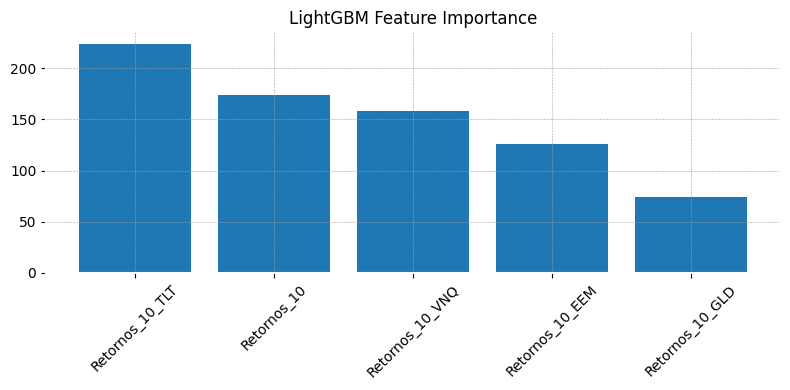

In [ ]:
# Feature Importance estándar del último modelo del rolling

meta_model = LGBMClassifier(
    n_estimators=200, max_depth=3, learning_rate=0.05, random_state=42, verbosity=-1
)
meta_model.fit(df_signals.loc[:N_TRAIN-1, features_meta], df_signals.loc[:N_TRAIN-1, "Objetivo_Señal"])
importances = meta_model.feature_importances_

df_feat_imp = pd.DataFrame({
    'Feature': features_meta,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nImportancia estándar LightGBM (último modelo):")
print(df_feat_imp)

plt.figure(figsize=(8,4))
plt.bar(df_feat_imp['Feature'], df_feat_imp['Importance'])
plt.xticks(rotation=45)
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

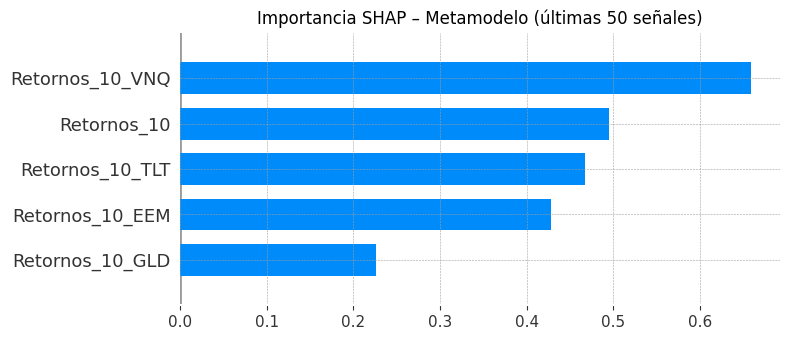

In [ ]:
import shap

# Explicabilidad SHAP sobre el último modelo y las últimas 50 señales
explainer = shap.TreeExplainer(meta_model)
shap_values = explainer.shap_values(df_signals.loc[N_TRAIN-50:N_TRAIN, features_meta])

# Crear el gráfico y capturar el objeto Axes
plt.figure()
ax = shap.summary_plot(
    shap_values,
    df_signals.loc[N_TRAIN-50:N_TRAIN, features_meta],
    plot_type="bar",
    show=False
)

# Eliminar el texto de descripción (generalmente es el xlabel)
plt.xlabel("")  # Quita la leyenda larga
plt.title("Importancia SHAP – Metamodelo (últimas 50 señales)")
plt.tight_layout()
plt.show()

# 7. Misceláneos

**Visualización temporal de señales**

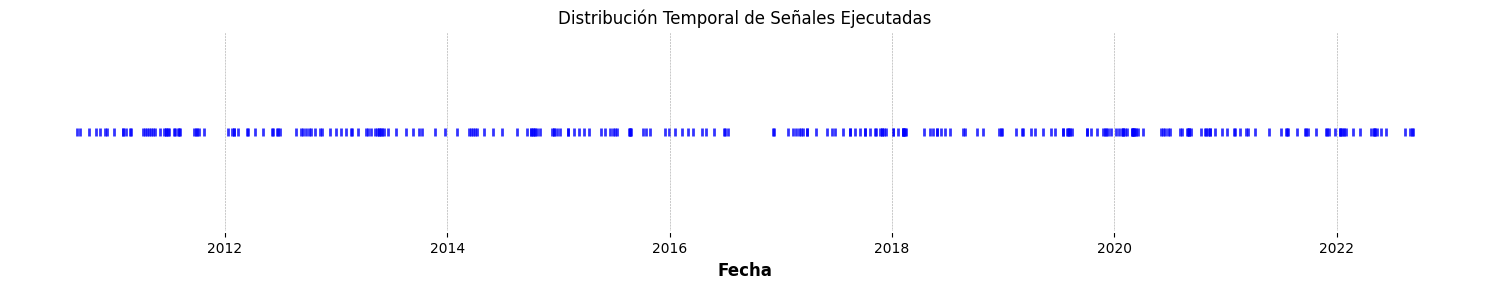

In [ ]:
# Asegúrate de que 'Fecha_Cierre' es datetime
df_train['Fecha_Cierre'] = pd.to_datetime(df_train['Fecha_Cierre'])

# Extrae sólo las señales ejecutadas
df_signals = df_train[df_train['Señal'] == 1].copy()

plt.figure(figsize=(15, 3))
plt.scatter(df_signals['Fecha_Cierre'], [1]*len(df_signals), marker='|', color='b', alpha=0.8)
plt.title('Distribución Temporal de Señales Ejecutadas')
plt.yticks([])
plt.xlabel('Fecha')
plt.tight_layout()
plt.show()

**Distribución de distancias entre señales**

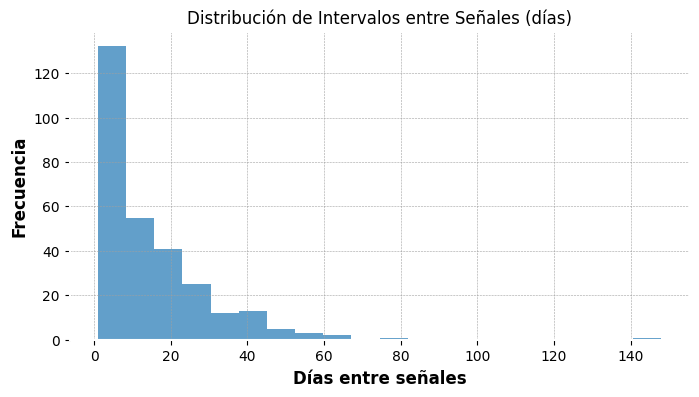

Media días entre señales: 15.1  |  Mediana: 11.0


In [ ]:
signal_dates = df_signals['Fecha_Cierre'].sort_values()
signal_lags = signal_dates.diff().dt.days.dropna()

plt.figure(figsize=(8,4))
plt.hist(signal_lags, bins=20, alpha=0.7)
plt.title('Distribución de Intervalos entre Señales (días)')
plt.xlabel('Días entre señales')
plt.ylabel('Frecuencia')
plt.show()

print(f"Media días entre señales: {signal_lags.mean():.1f}  |  Mediana: {signal_lags.median():.1f}")

**Análisis de rachas (streaks) de señales ganadoras y perdedoras**

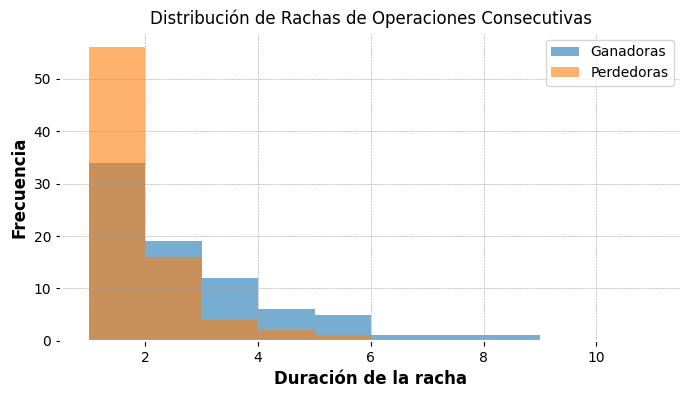

Racha ganadora más larga: 8
Racha perdedora más larga: 5


In [ ]:
# Crea una serie de +1 (ganancia), -1 (pérdida), 0 (break-even)
df_signals['Resultado'] = np.where(
    df_signals['Objetivo_Señal'] == 1, 1, -1
)

# Calcula las rachas (streaks) usando run length encoding
def streaks(arr):
    # Devuelve: lista de (valor, longitud)
    from itertools import groupby
    return [(k, sum(1 for _ in g)) for k,g in groupby(arr)]

streak_list = streaks(df_signals['Resultado'].values)
streak_df = pd.DataFrame(streak_list, columns=['Resultado', 'Duración'])

# Histogramas
plt.figure(figsize=(8,4))
plt.hist(streak_df.loc[streak_df['Resultado']==1, 'Duración'], bins=range(1,12), alpha=0.6, label='Ganadoras')
plt.hist(streak_df.loc[streak_df['Resultado']==-1, 'Duración'], bins=range(1,12), alpha=0.6, label='Perdedoras')
plt.title('Distribución de Rachas de Operaciones Consecutivas')
plt.xlabel('Duración de la racha')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Info sobre rachas máximas
max_winning_streak = streak_df.loc[streak_df['Resultado']==1, 'Duración'].max()
max_losing_streak = streak_df.loc[streak_df['Resultado']==-1, 'Duración'].max()
print(f"Racha ganadora más larga: {max_winning_streak}")
print(f"Racha perdedora más larga: {max_losing_streak}")

In [ ]:
# Frecuencias de rachas de cada tipo
summary = streak_df.groupby(['Resultado', 'Duración']).size().unstack(fill_value=0)
print("Tabla resumen de frecuencia de rachas:")
print(summary)

Tabla resumen de frecuencia de rachas:
Duración    1   2   3  4  5  6  7  8
Resultado                           
-1         56  16   4  2  1  0  0  0
 1         34  19  12  6  5  1  1  1


**Probabilidad empírica de ganar condicionada a la longitud de la racha previa**

In [ ]:
from collections import defaultdict

resultados = df_signals['Resultado'].values  # asume 1=win, -1=loss

# Mapear: longitud de racha previa (ganadora) --> ¿qué pasó después?
racha_map = defaultdict(list)

streak = 0
for i in range(len(resultados)-1):  # último no tiene "siguiente"
    if resultados[i] == 1:
        streak += 1
    else:
        streak = 0
    # solo analizamos lo que ocurre después de cada racha de wins
    racha_map[streak].append(resultados[i+1])

# Calcula probabilidad de win/loss tras cada longitud de racha
for k in sorted(racha_map.keys()):
    siguientes = racha_map[k]
    if len(siguientes) >= 10:  # para estadística decente
        prob_win = np.mean(np.array(siguientes) == 1)
        prob_loss = np.mean(np.array(siguientes) == -1)
        print(f"Tras {k} wins seguidos: N={len(siguientes)} | P(Win sig): {prob_win:.2f} | P(Loss sig): {prob_loss:.2f}")

Tras 0 wins seguidos: N=112 | P(Win sig): 0.70 | P(Loss sig): 0.30
Tras 1 wins seguidos: N=79 | P(Win sig): 0.57 | P(Loss sig): 0.43
Tras 2 wins seguidos: N=45 | P(Win sig): 0.58 | P(Loss sig): 0.42
Tras 3 wins seguidos: N=26 | P(Win sig): 0.54 | P(Loss sig): 0.46
Tras 4 wins seguidos: N=14 | P(Win sig): 0.57 | P(Loss sig): 0.43


In [ ]:
from collections import defaultdict

# Supón que tu dataframe es df_signals y la columna Resultado ya está definida:
# 1 = Ganancia, -1 = Pérdida
resultados = df_signals['Resultado'].values  # vector de 1 (ganada) y -1 (perdida)

# Diccionario: racha de pérdidas previa --> resultado de la siguiente operación
racha_loss_map = defaultdict(list)

streak = 0
for i in range(len(resultados) - 1):  # hasta el penúltimo
    if resultados[i] == -1:
        streak += 1
    else:
        streak = 0
    # Solo nos interesa después de rachas de pérdidas (streak >= 1)
    racha_loss_map[streak].append(resultados[i + 1])

# Imprime probabilidad condicional de ganancia o pérdida tras cada racha de pérdidas
print("Probabilidad condicional de ganar/perder tras racha de pérdidas:")
for k in sorted(racha_loss_map.keys()):
    siguientes = racha_loss_map[k]
    if k >= 1 and len(siguientes) >= 10:  # Solo muestra si hay muestra razonable
        prob_win = np.mean(np.array(siguientes) == 1)
        prob_loss = np.mean(np.array(siguientes) == -1)
        print(f"Tras {k} pérdidas seguidas (N={len(siguientes)}): "
              f"P(Win sig) = {prob_win:.2f} | P(Loss sig) = {prob_loss:.2f}")

Probabilidad condicional de ganar/perder tras racha de pérdidas:
Tras 1 pérdidas seguidas (N=78): P(Win sig) = 0.71 | P(Loss sig) = 0.29
Tras 2 pérdidas seguidas (N=23): P(Win sig) = 0.70 | P(Loss sig) = 0.30
